In [1]:
import random
from itertools import cycle
from dateutil.parser import parse

import numpy as np 
import pandas as pd

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns

In [2]:
data_folder = "../input/g-research-crypto-forecasting/"
!ls  $data_folder

asset_details.csv	       example_test.csv  supplemental_train.csv
example_sample_submission.csv  gresearch_crypto  train.csv


In [3]:
asset_details = pd.read_csv(data_folder + 'asset_details.csv')
asset_details.head()

Asset_ID    Weight        Asset_Name
0         2  2.397895      Bitcoin Cash
1         0  4.304065      Binance Coin
2         1  6.779922           Bitcoin
3         5  1.386294            EOS.IO
4         7  2.079442  Ethereum Classic

In [4]:
df = pd.read_csv(data_folder + "train.csv")
df.head()

timestamp  Asset_ID  Count        Open        High         Low  \
0  1514764860         2   40.0   2376.5800   2399.5000   2357.1400   
1  1514764860         0    5.0      8.5300      8.5300      8.5300   
2  1514764860         1  229.0  13835.1940  14013.8000  13666.1100   
3  1514764860         5   32.0      7.6596      7.6596      7.6567   
4  1514764860         7    5.0     25.9200     25.9200     25.8740   

        Close       Volume          VWAP    Target  
0   2374.5900    19.233005   2373.116392 -0.004218  
1      8.5300    78.380000      8.530000 -0.014399  
2  13850.1760    31.550062  13827.062093 -0.014643  
3      7.6576  6626.713370      7.657713 -0.013922  
4     25.8770   121.087310     25.891363 -0.008264

# Preprocessing

In [5]:
# splitting
assets = list()

for index, row in asset_details.iterrows():
    asset = {'name': row['Asset_Name'], 
             'df': (df[df["Asset_ID"] == row['Asset_ID']]).drop('Asset_ID', axis=1)}
    assets.append(asset)

In [6]:
# changing timestamp to datetime object and changing it to index
# handling missing target values 
# making lag constant

for asset in assets:
    asset['df'] = asset['df'].fillna(0)
    asset['df'] = asset['df'].set_index('timestamp')
    asset['df'] = asset['df'].reindex(range(asset['df'].index[0],asset['df'].index[-1]+60,60),method='pad')
    (asset['df']).index = pd.to_datetime((asset['df']).index, unit='s')

# EDA

## Plotting Closing Prices and Target

- after 2021, the prices follow a similar trend

In [7]:
def plot_columns(column_name, xlabel, ylabel):
    cy_col = cycle('bgrcmk')
    cy_no = cycle(range(14))
    fig, axs = plt.subplots(7, 2, figsize=(24, 42))

    for row in range(0, 7):
        for col in range(0, 2):
            asset_no = next(cy_no)

            axs[row, col].plot(assets[asset_no]['df'].index, 
                               assets[asset_no]['df'][column_name],
                               c=next(cy_col))
            axs[row, col].set_xlabel(xlabel)
            axs[row, col].set_ylabel(ylabel)
            axs[row, col].set_title(assets[asset_no]['name'])

    plt.show()

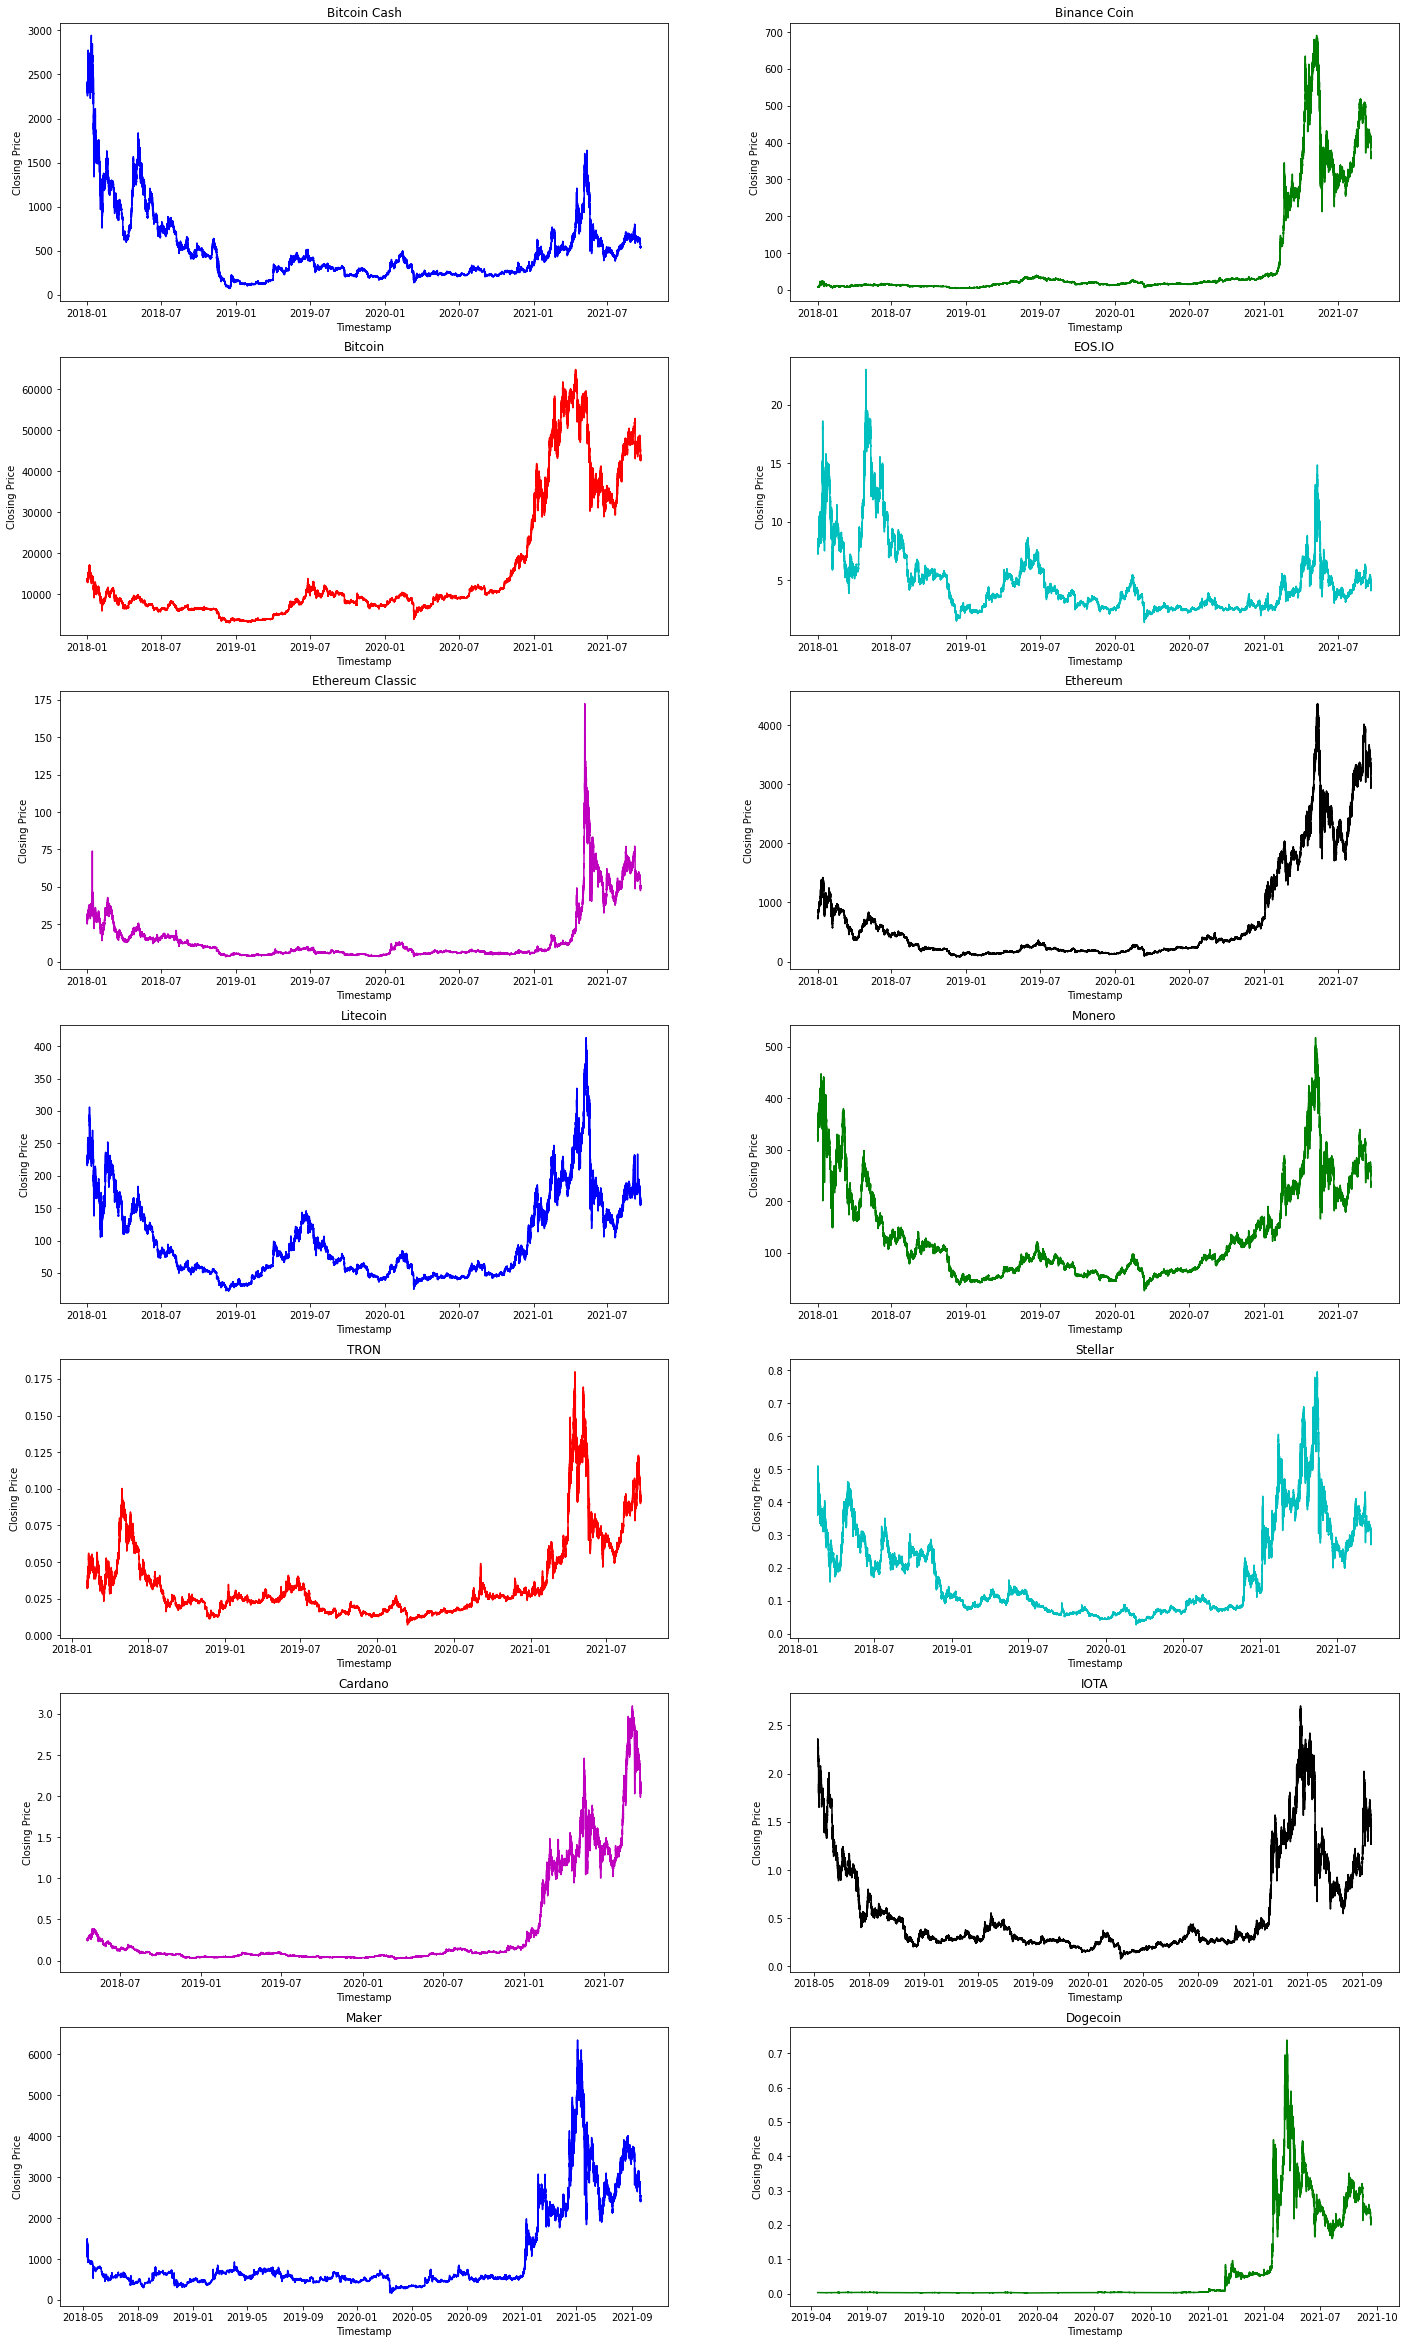

In [8]:
plot_columns('Close', 'Timestamp', 'Closing Price')


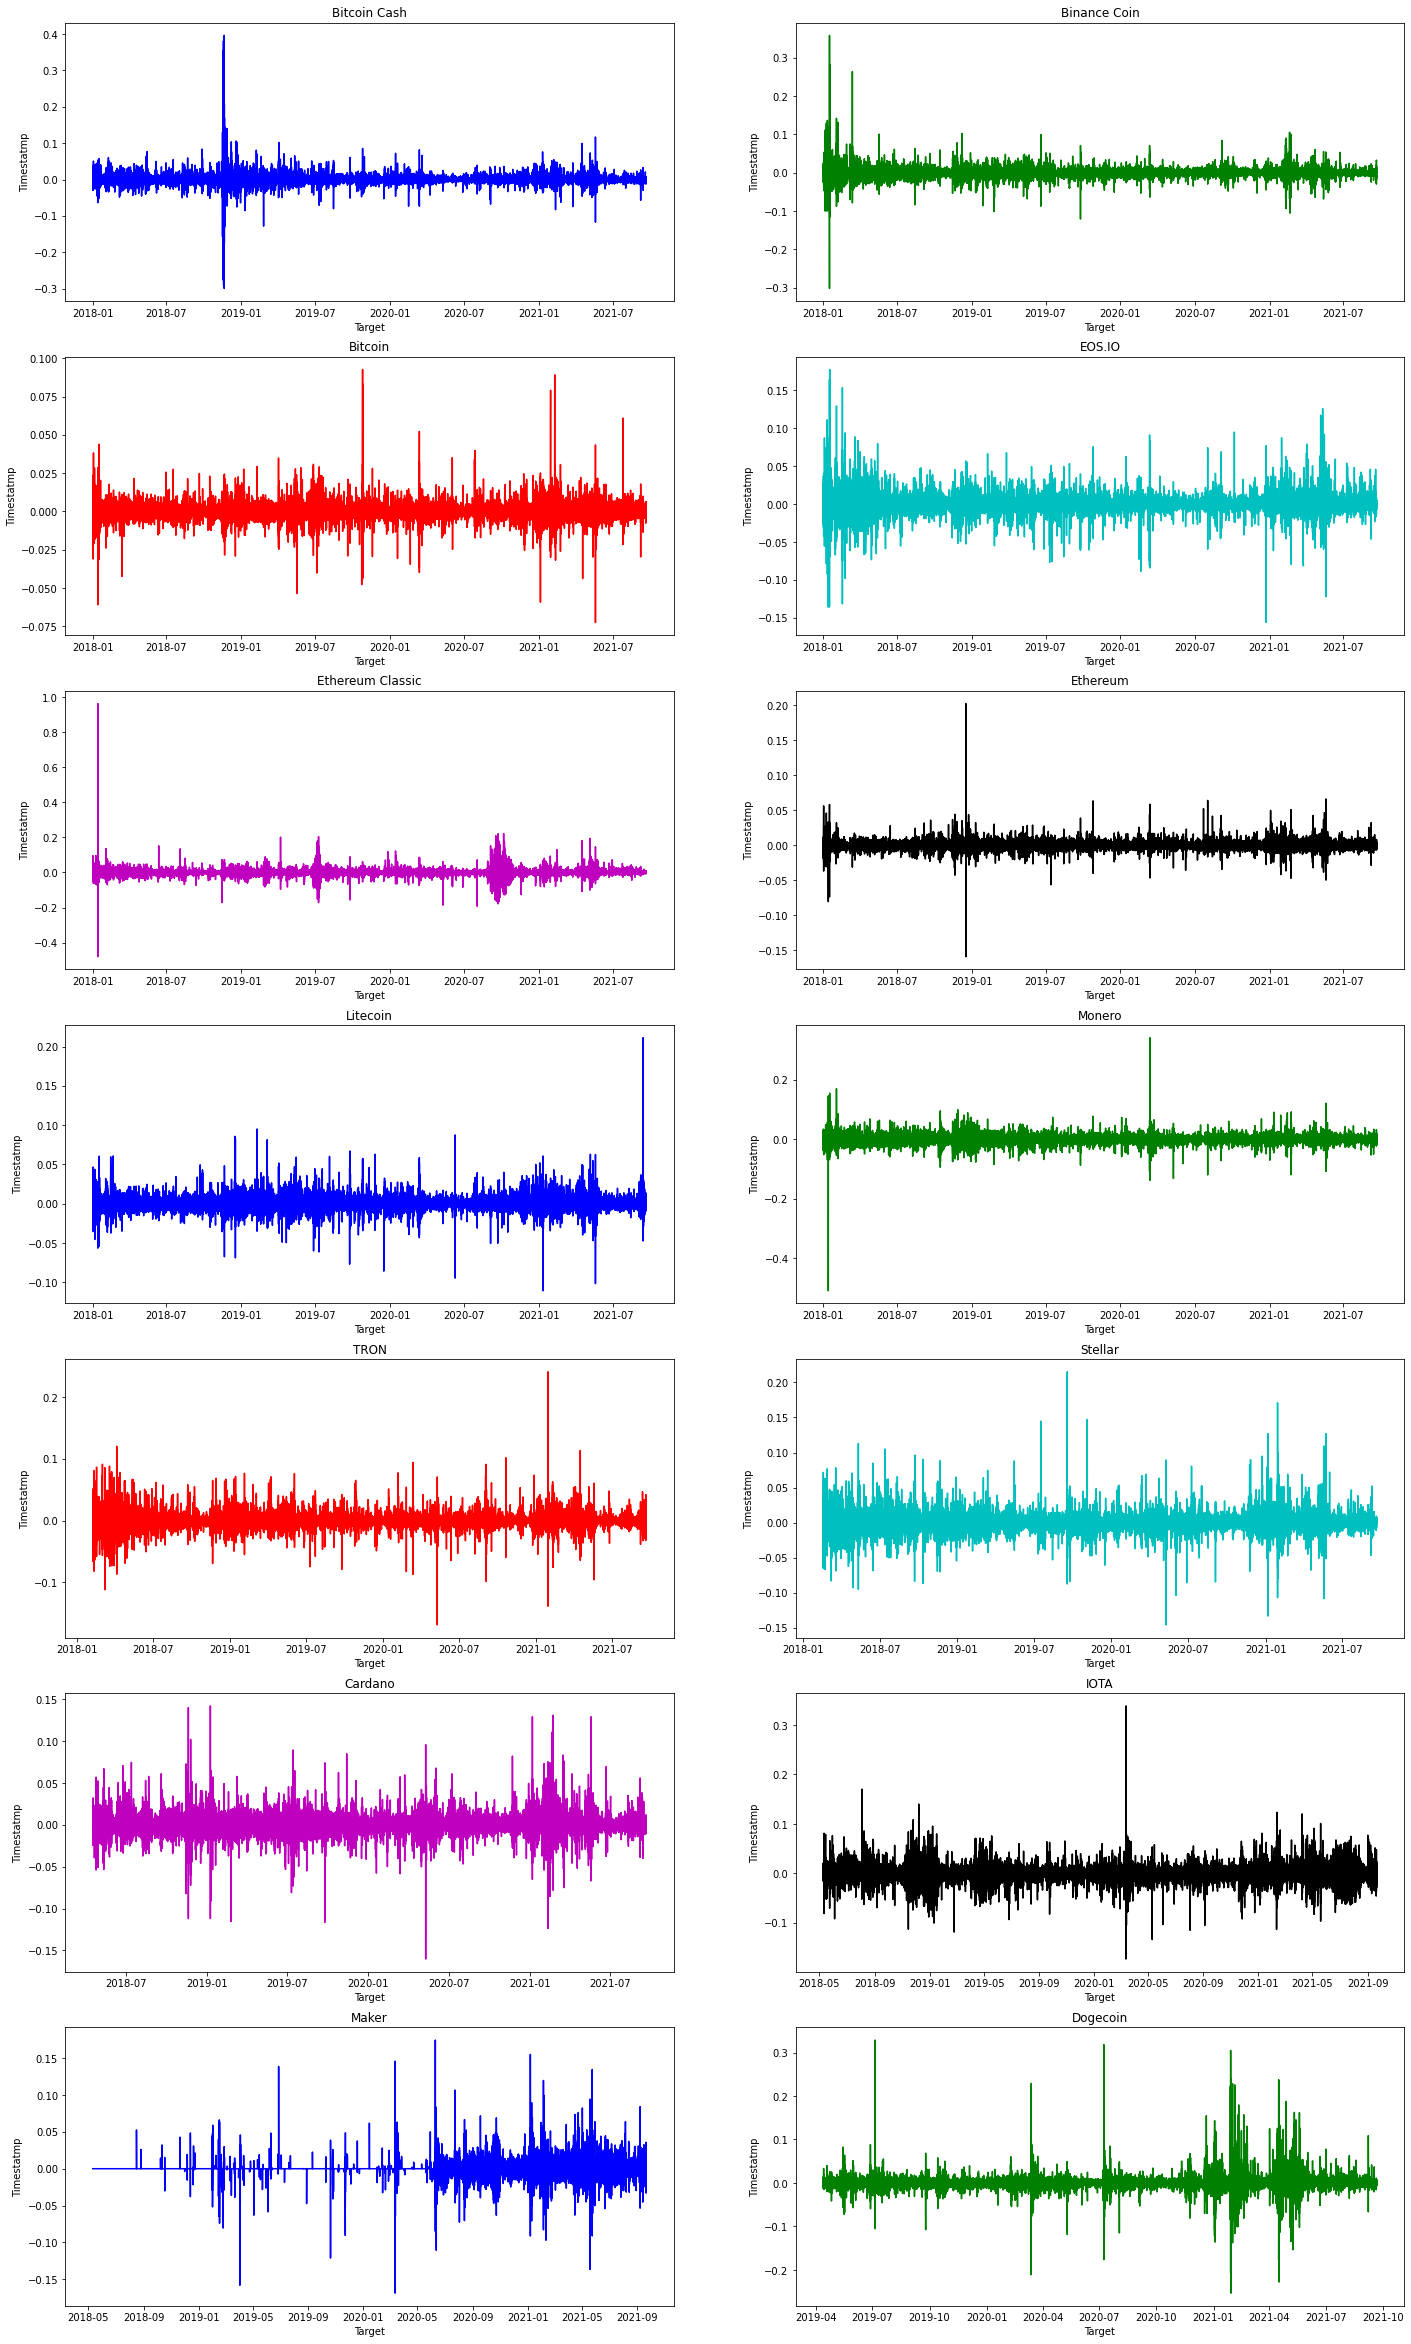

In [9]:
plot_columns('Target', 'Target', 'Timestatmp')

## Correlation between closing price of diff currencies

- high, but this could be becuase most of the currencies were not very active before 2021
- plotting correlation vs time (after 2021), correlation is high but very variable

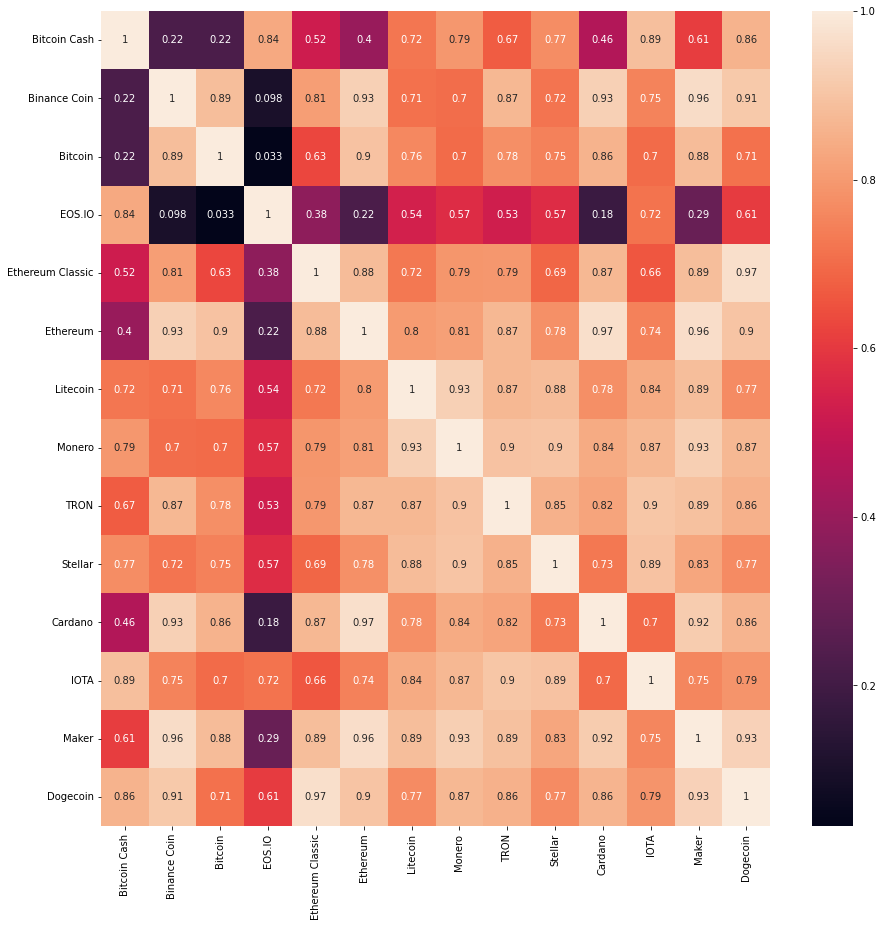

In [10]:
closing_prices = {}

for asset in assets:
    closing_prices[asset['name']] = asset['df'].Close
    
closing_prices_df = pd.DataFrame(closing_prices)

correlations = closing_prices_df.corr()
plt.figure(figsize=(15,15))
sns.heatmap(correlations, annot=True)
plt.show()

In [11]:
# plotting corr vs time of bitcoin vs diff assets
cy_col = cycle('bgrcmk')
cy_no = cycle(range(1, 15))


def plot_corr_vs_time(base_asset_prices, other_asset_name, row, col, axs):
    other_asset_prices = (closing_prices[other_asset_name]).    \
                            loc[(parse("Jan 1 2021 12:00AM")):(parse("Aug 1 2021 12:00AM"))]
    other_asset_prices.rename(other_asset_name, inplace=True)
    
    combined_df = pd.concat([bitcoin_prices, other_asset_prices], axis=1)
    corr_vs_time = combined_df.groupby(combined_df.index.isocalendar().week).corr().loc[:, 'bitcoin'].loc[:, other_asset_name]
    
    axs[row, col].plot(corr_vs_time[:-1], c=next(cy_col))
    axs[row, col].set_xlabel('Time(in weeks)')
    axs[row, col].set_ylabel('Correlation')
    axs[row, col].set_title(other_asset_name)

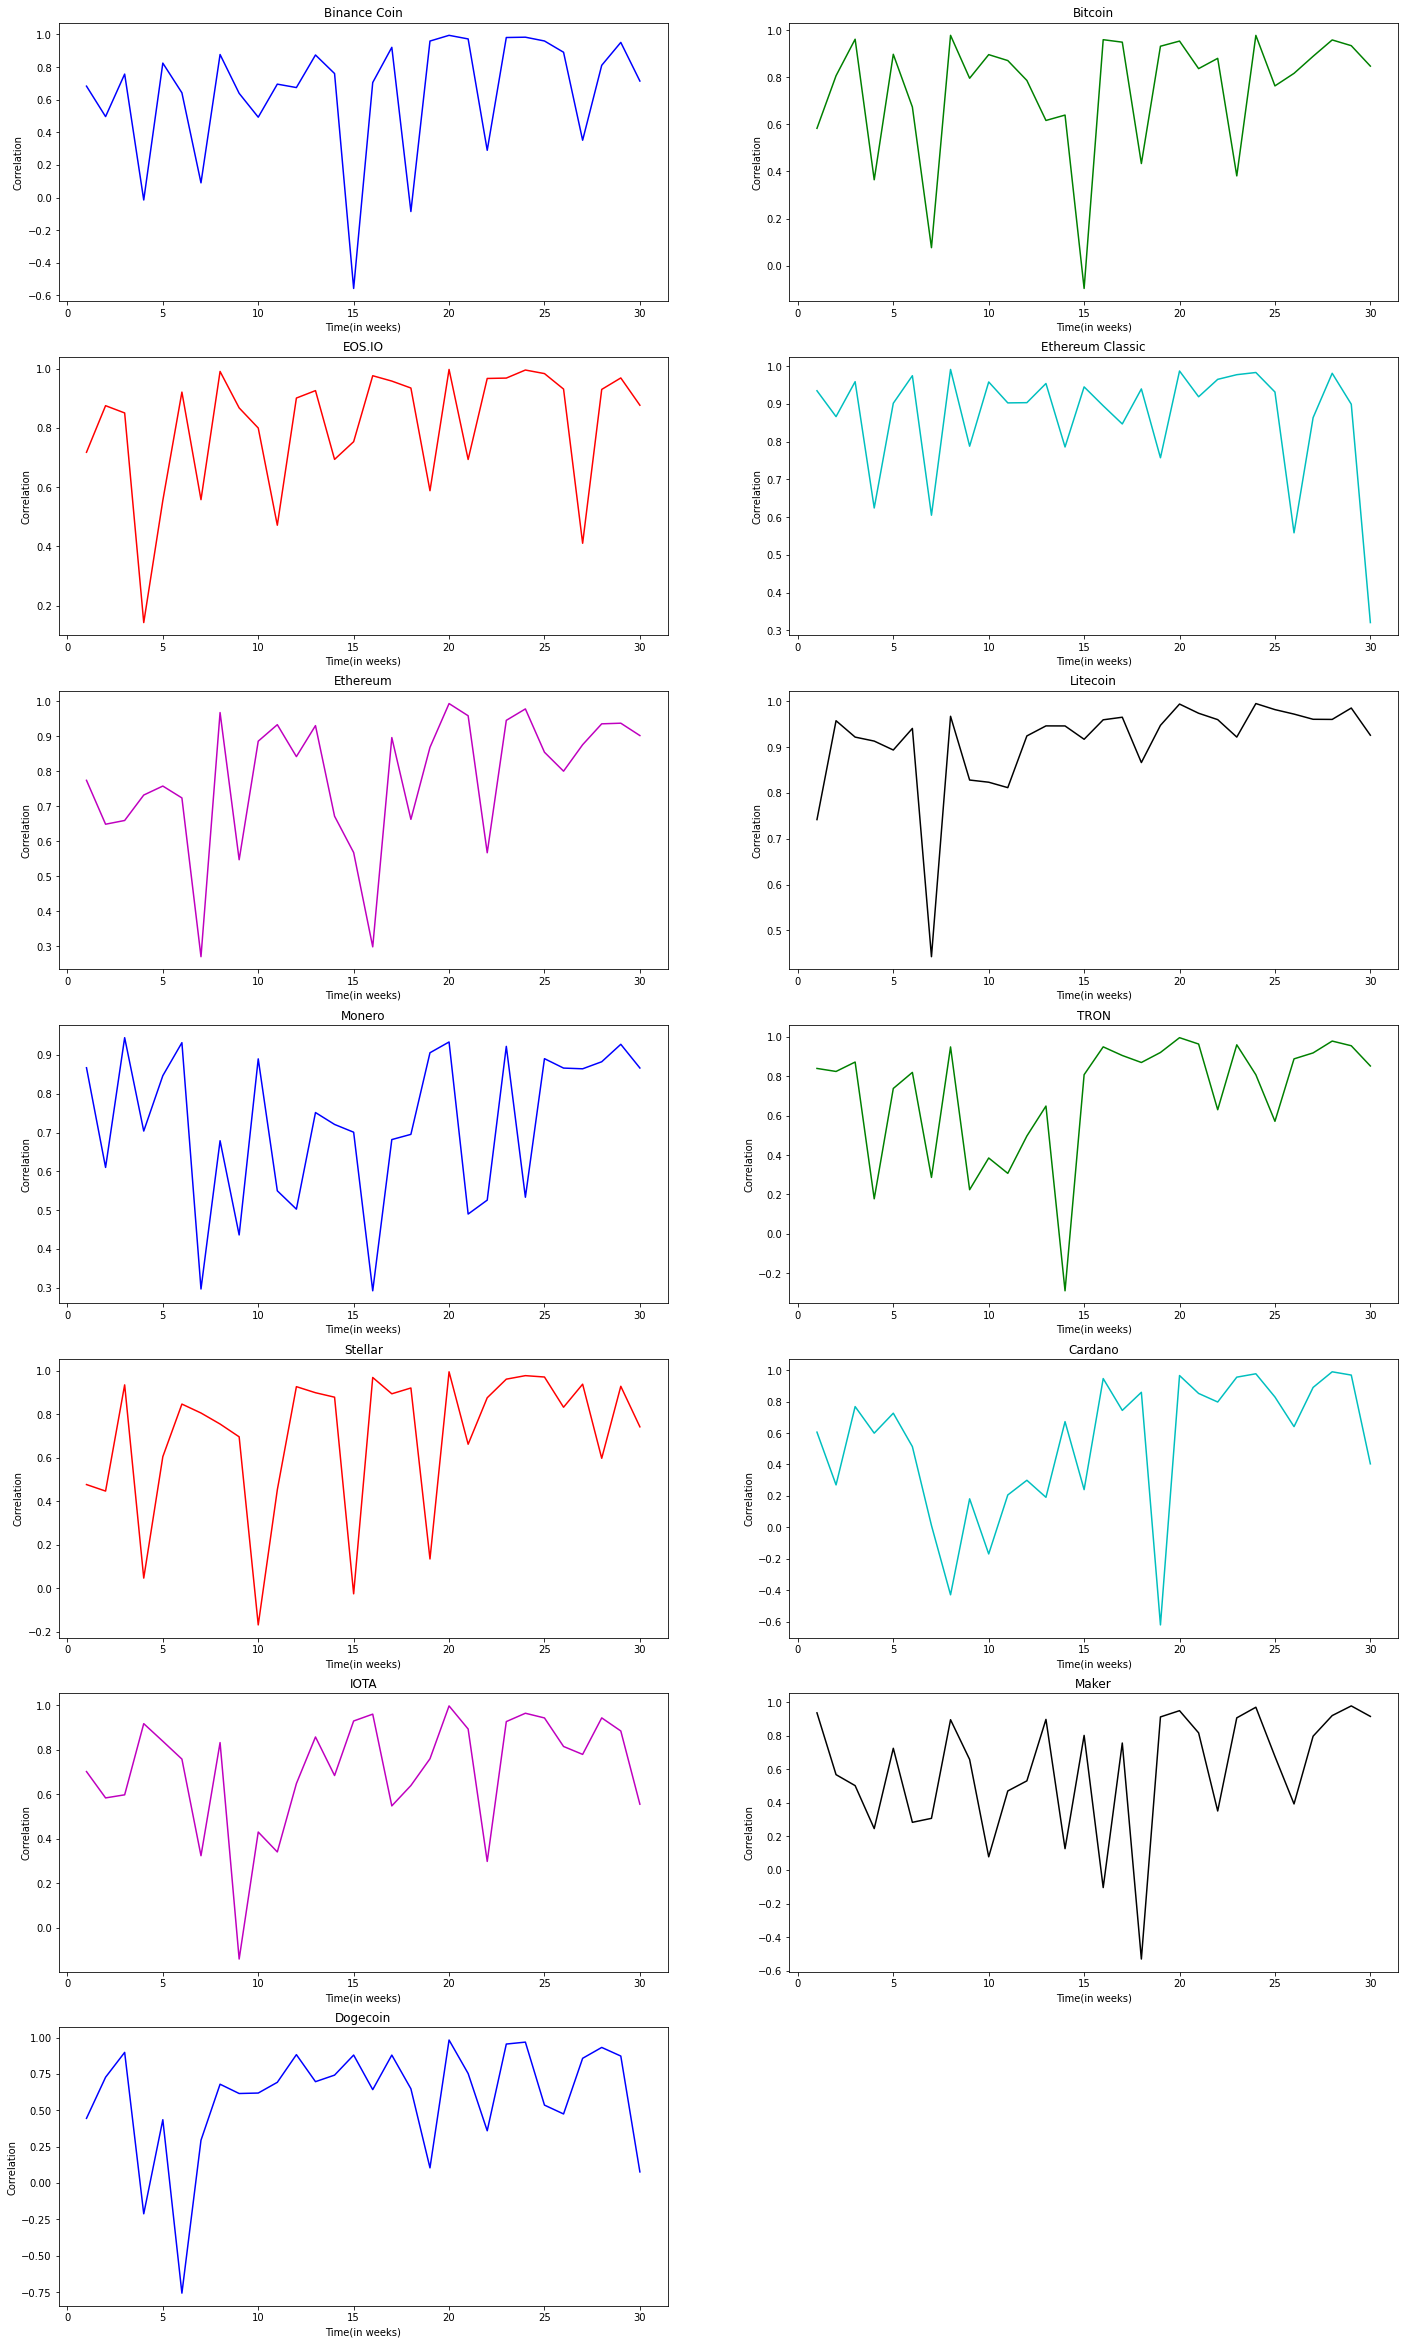

In [12]:
fig, axs = plt.subplots(7, 2, figsize=(24, 42))

bitcoin_prices = (closing_prices[assets[0]['name']]).loc[(parse("Jan 1 2021 12:00AM")):(parse("Aug 1 2021 12:00AM"))]
bitcoin_prices.rename('bitcoin', inplace=True)

for row in range(0, 7):
    for col in range(0, 2):
        asset_no = next(cy_no)
        
        if(asset_no == 14):
            break
        plot_corr_vs_time(bitcoin_prices, assets[asset_no]['name'], row, col, axs)    
        
fig.delaxes(axs[6,1]) 
plt.show()

## Time Series Decomposition

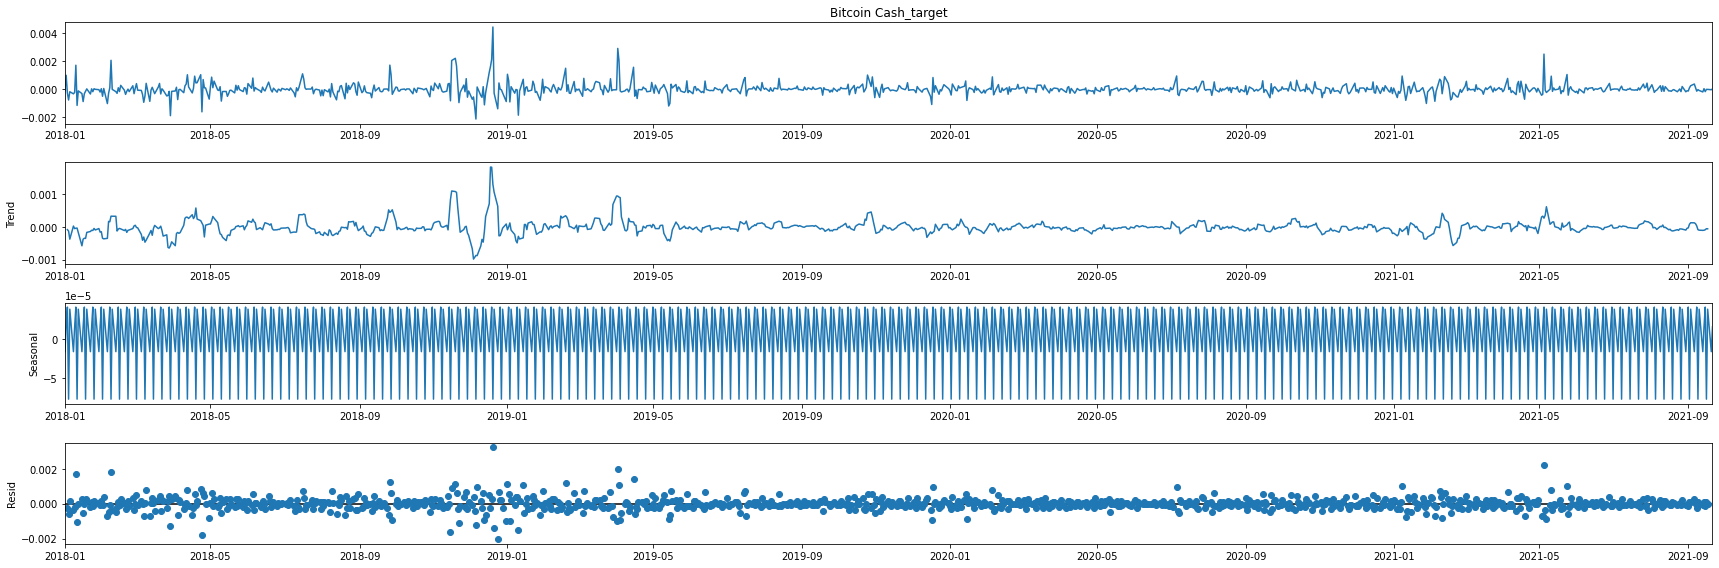

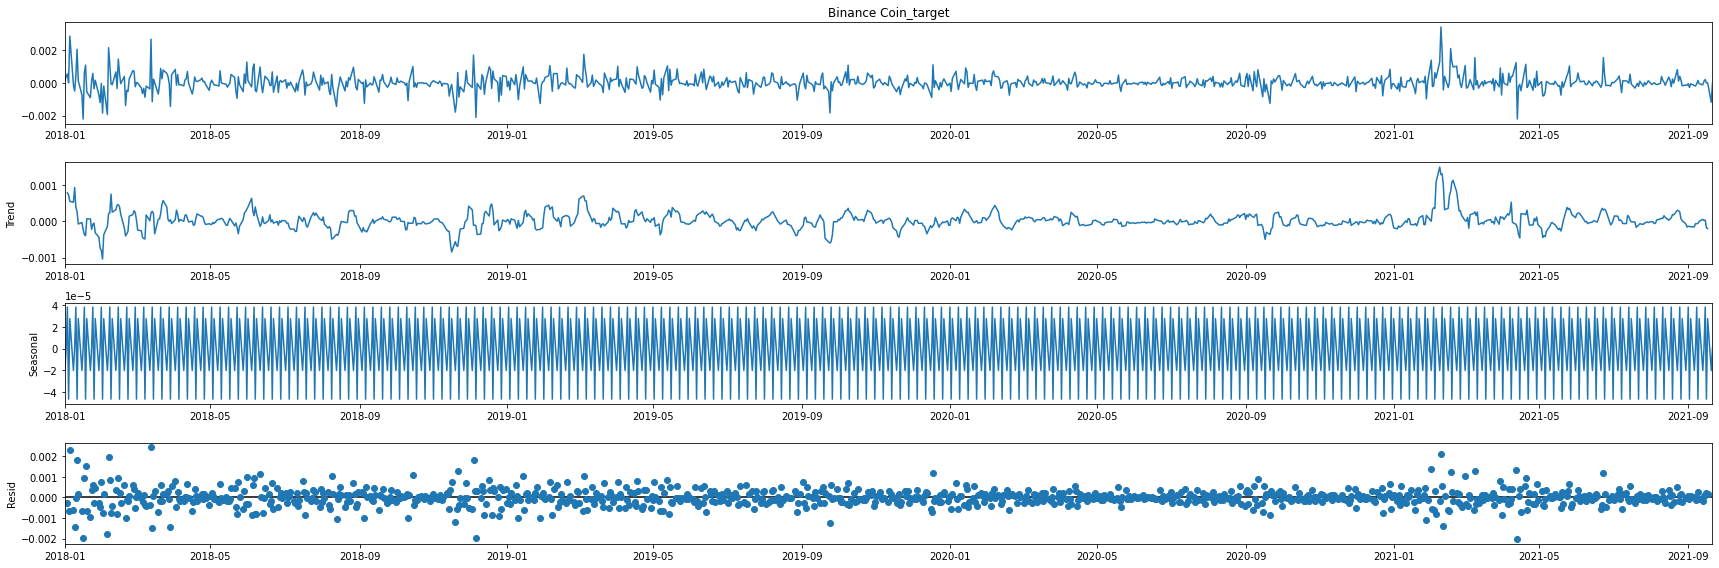

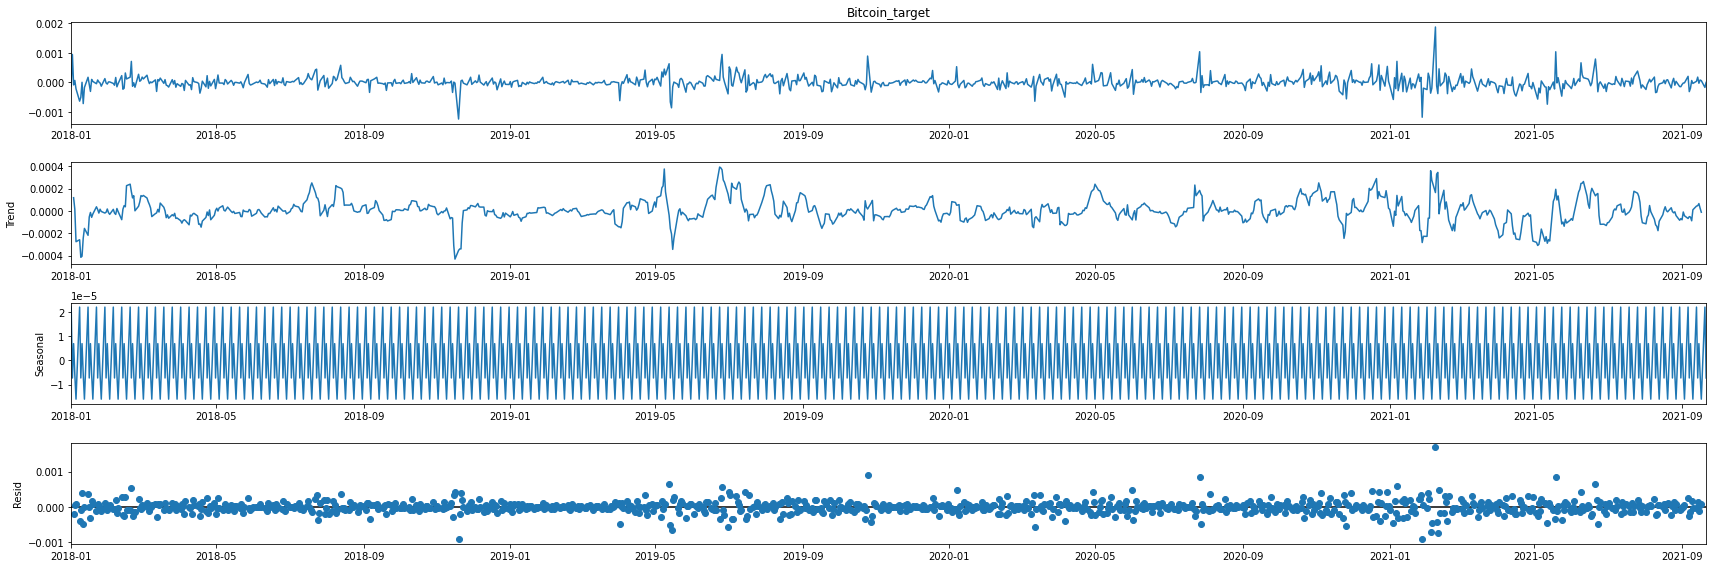

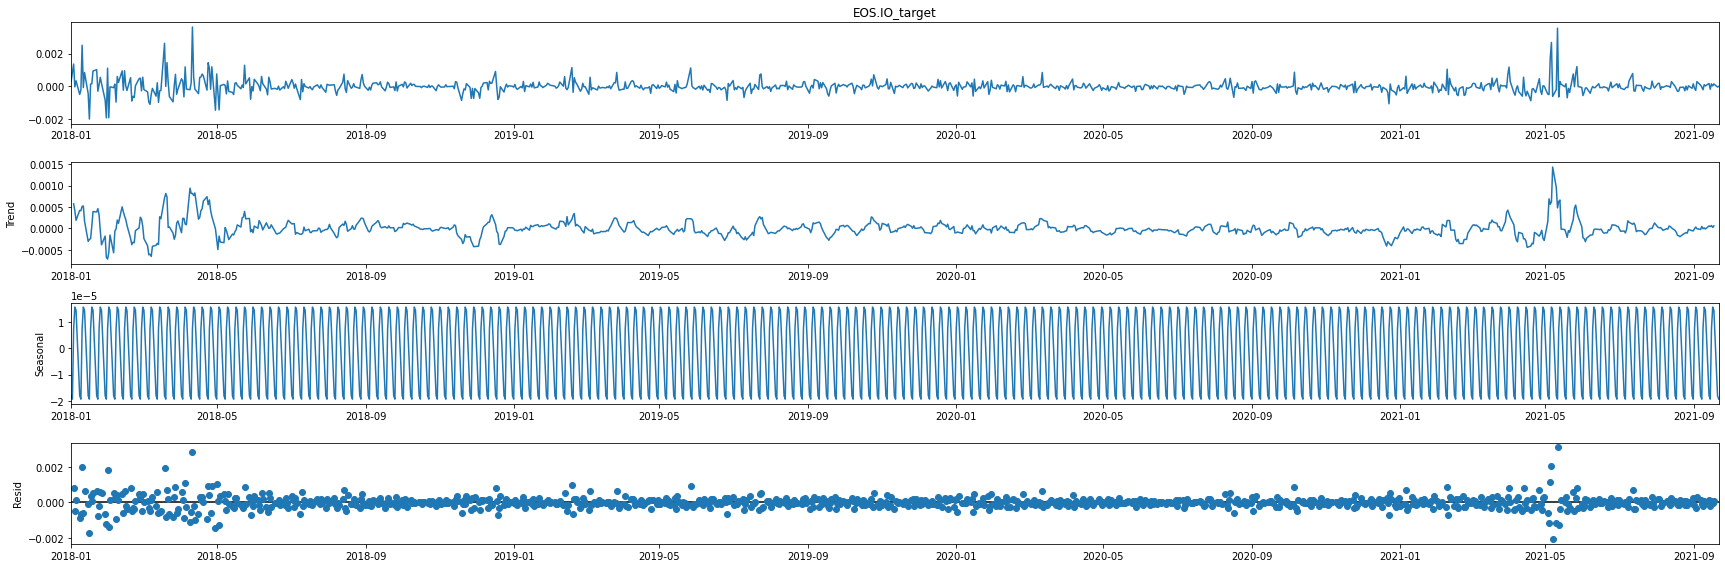

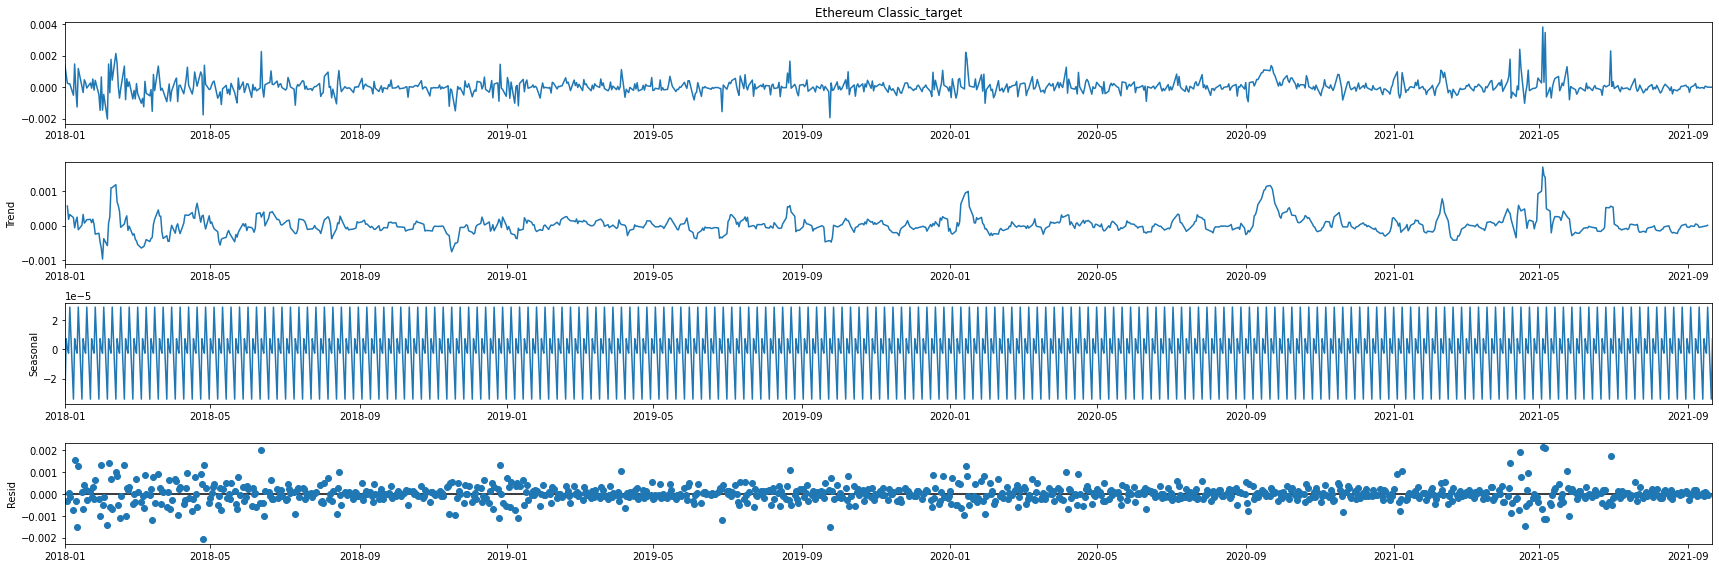

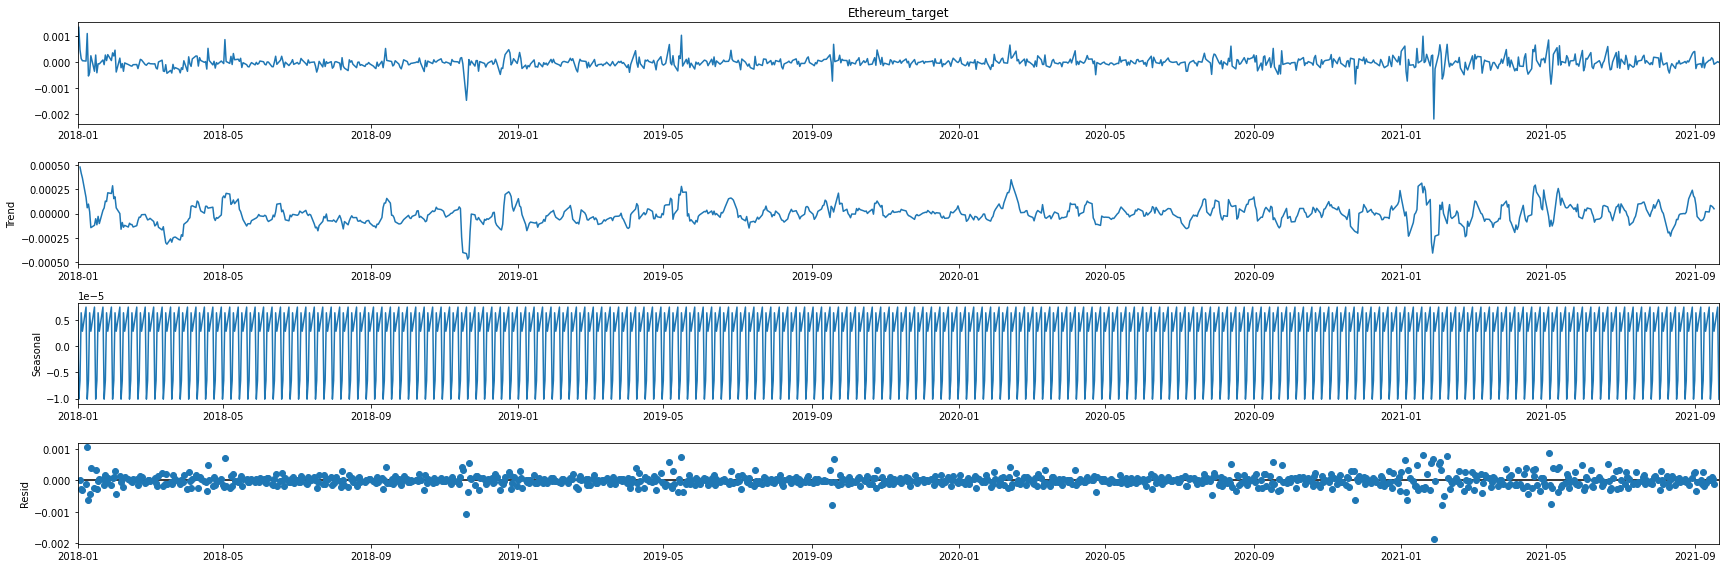

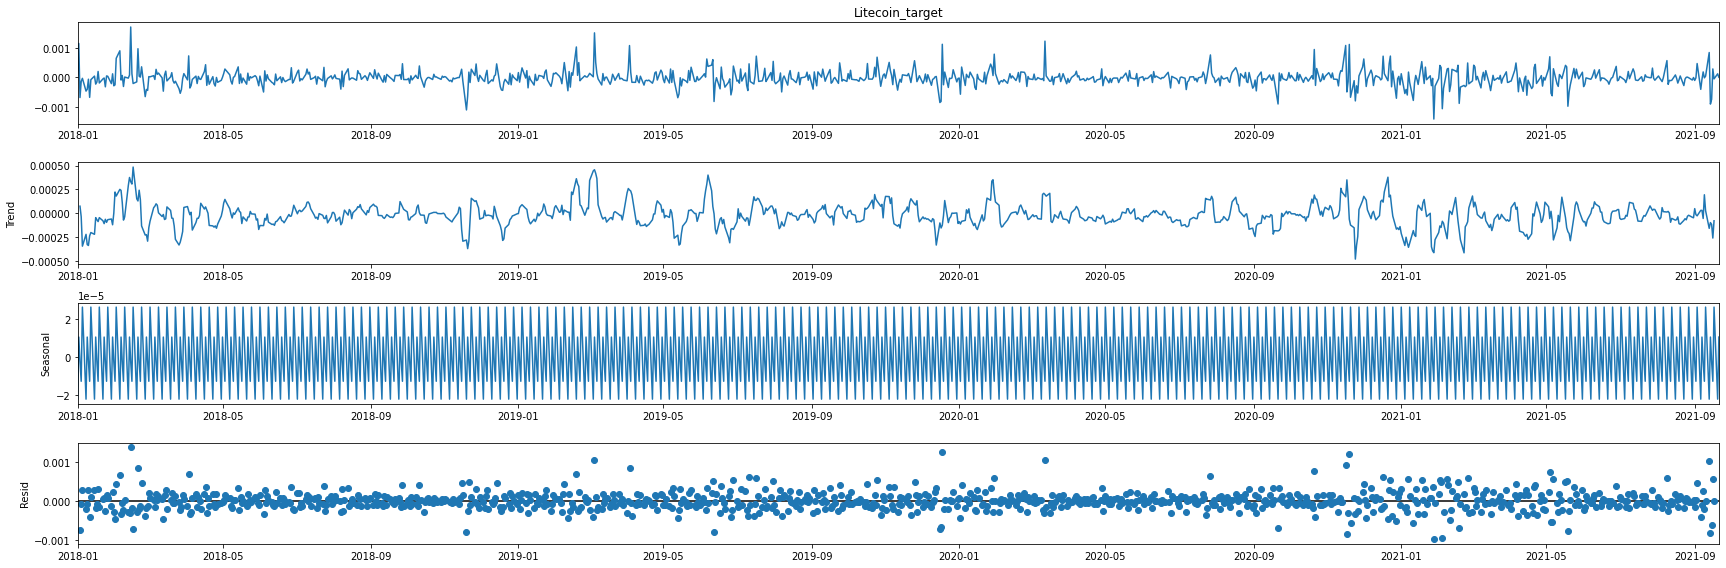

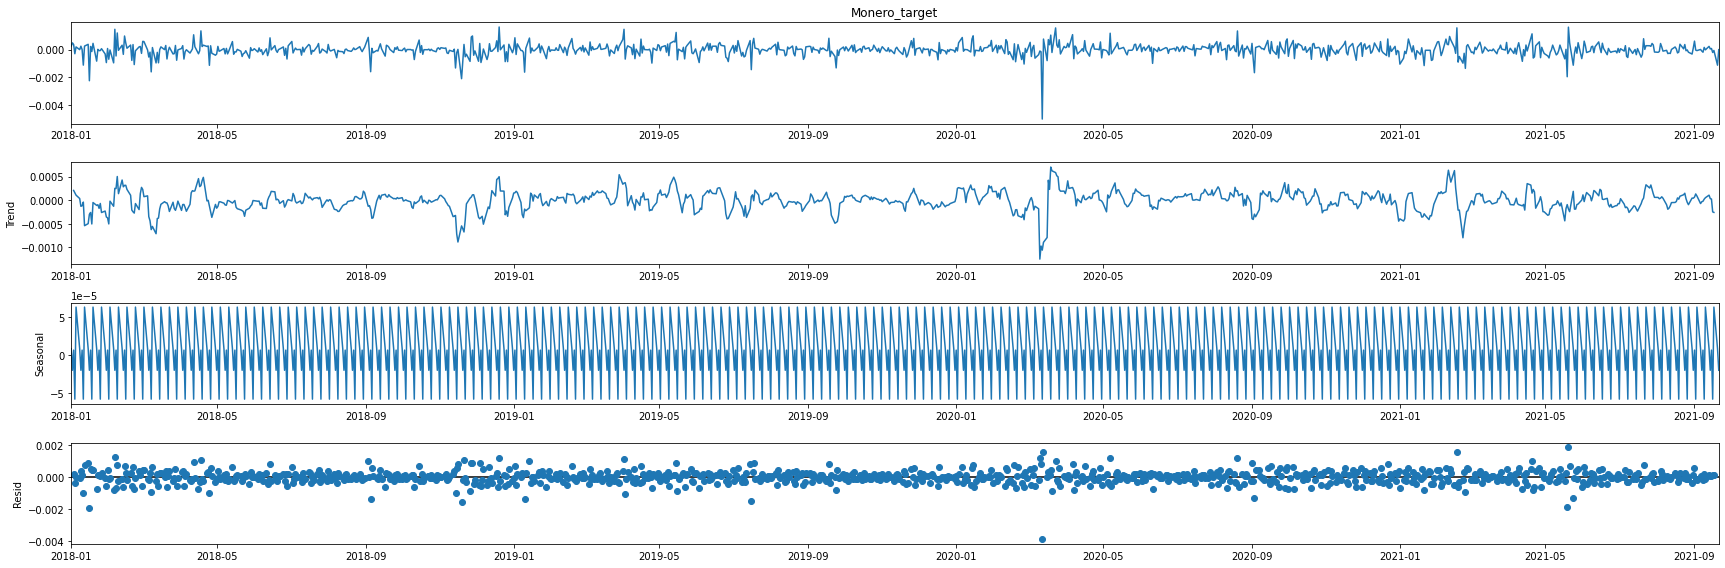

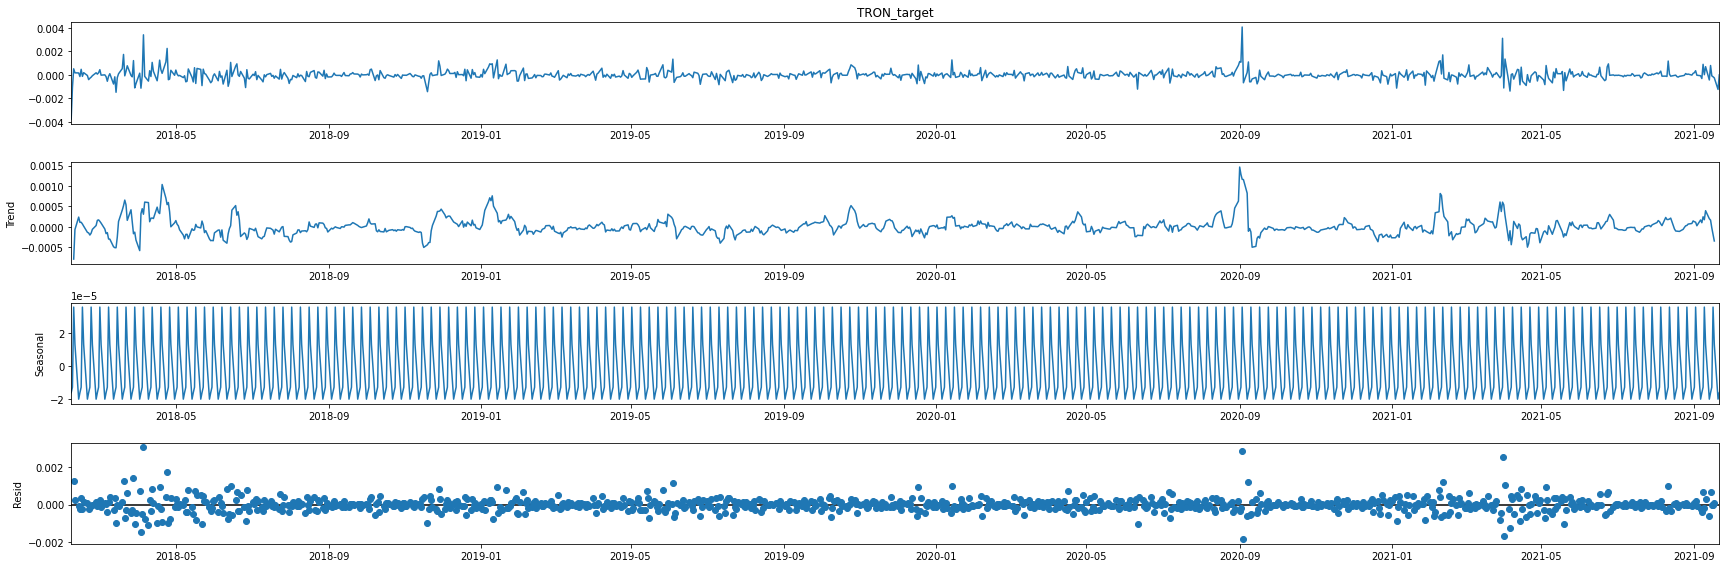

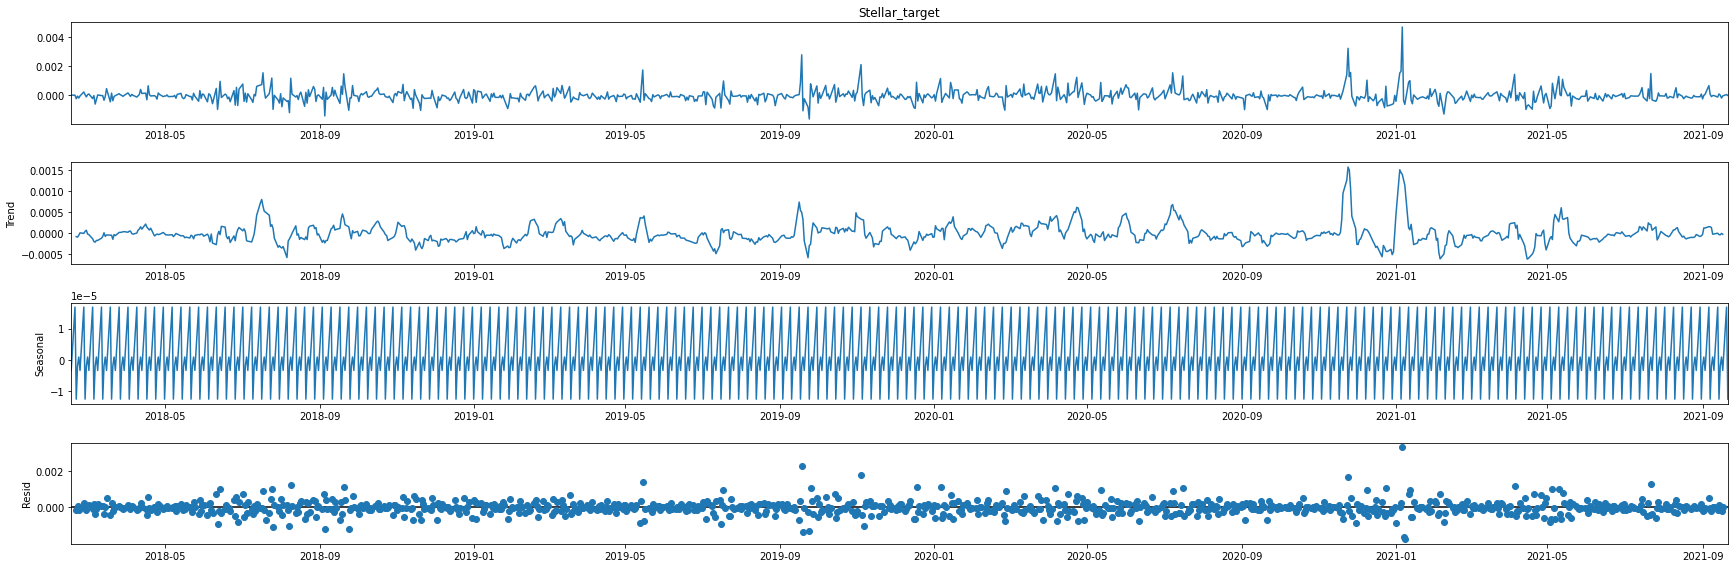

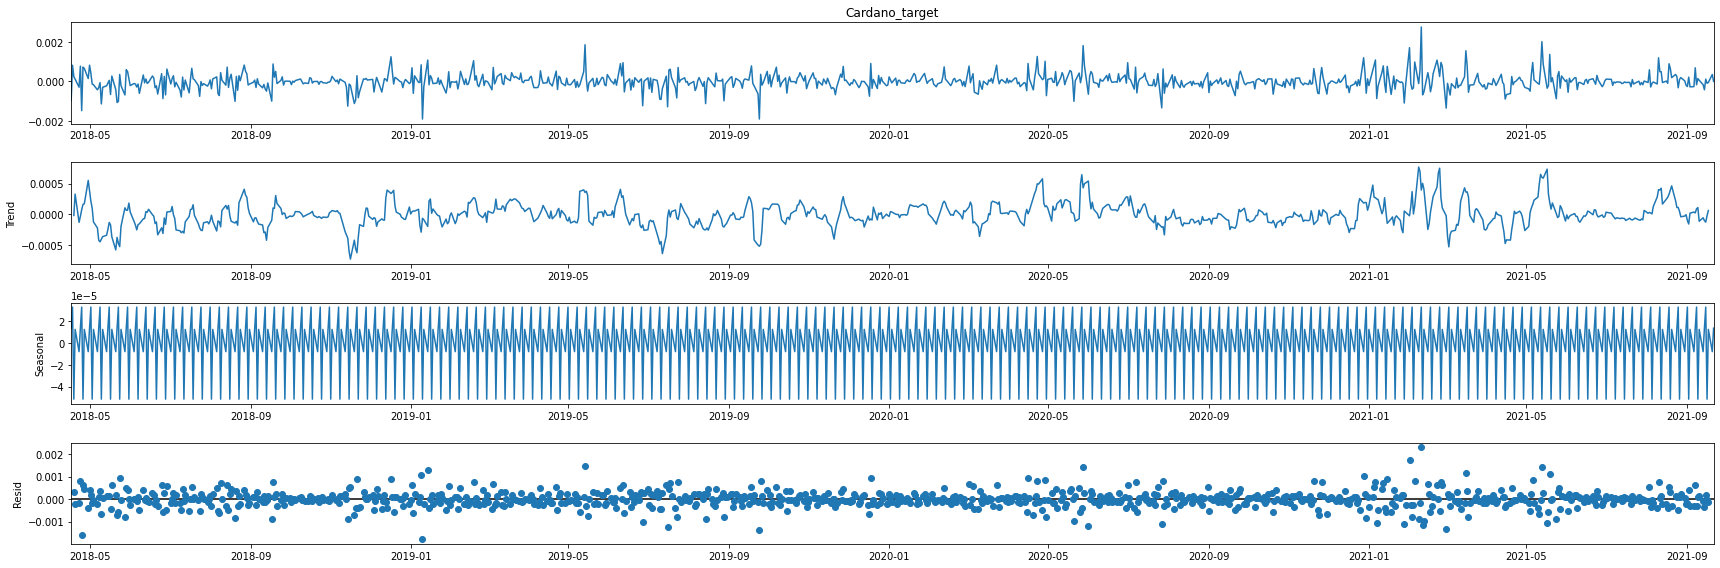

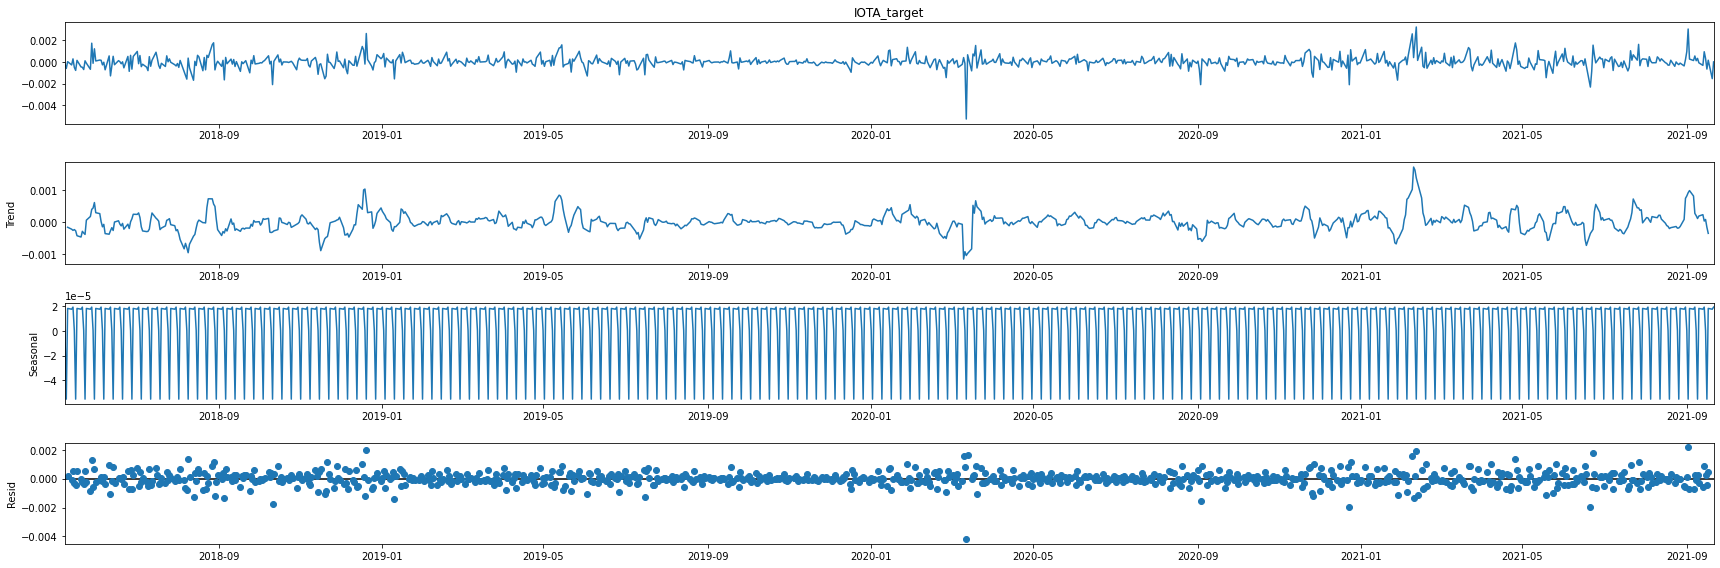

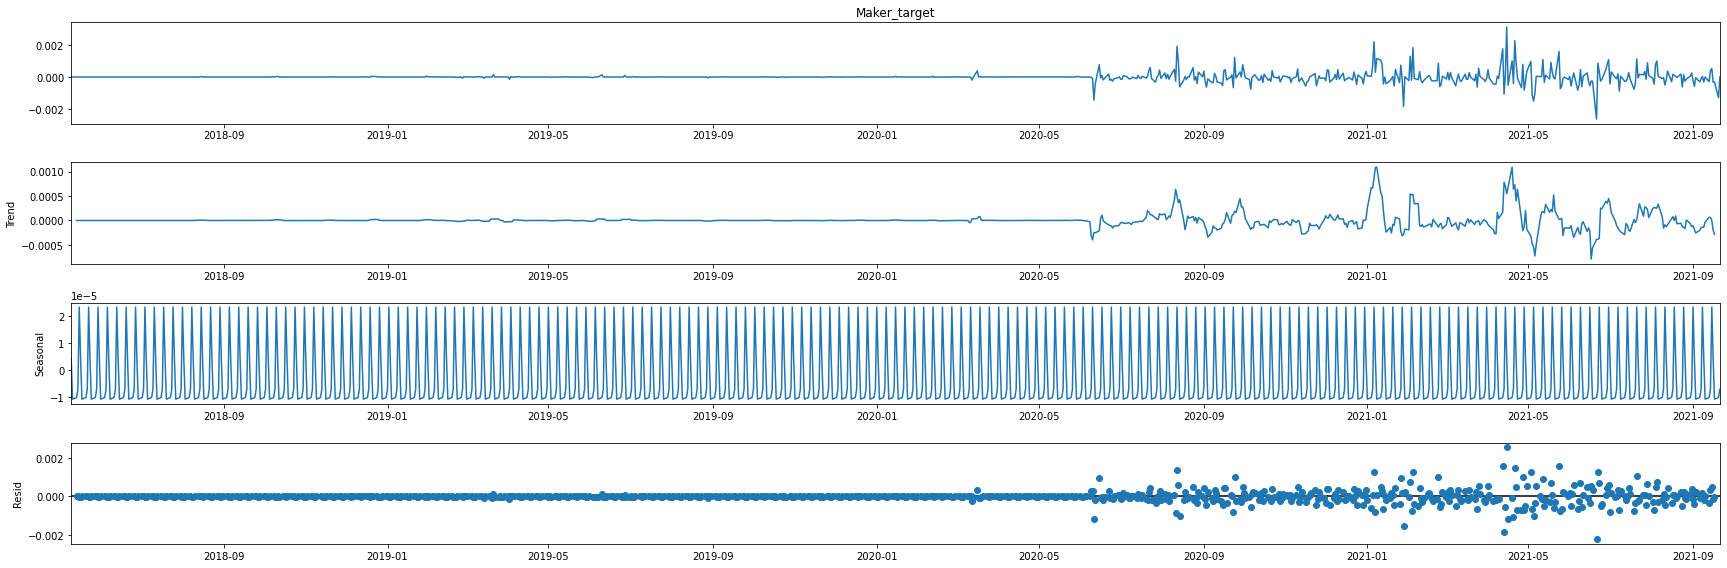

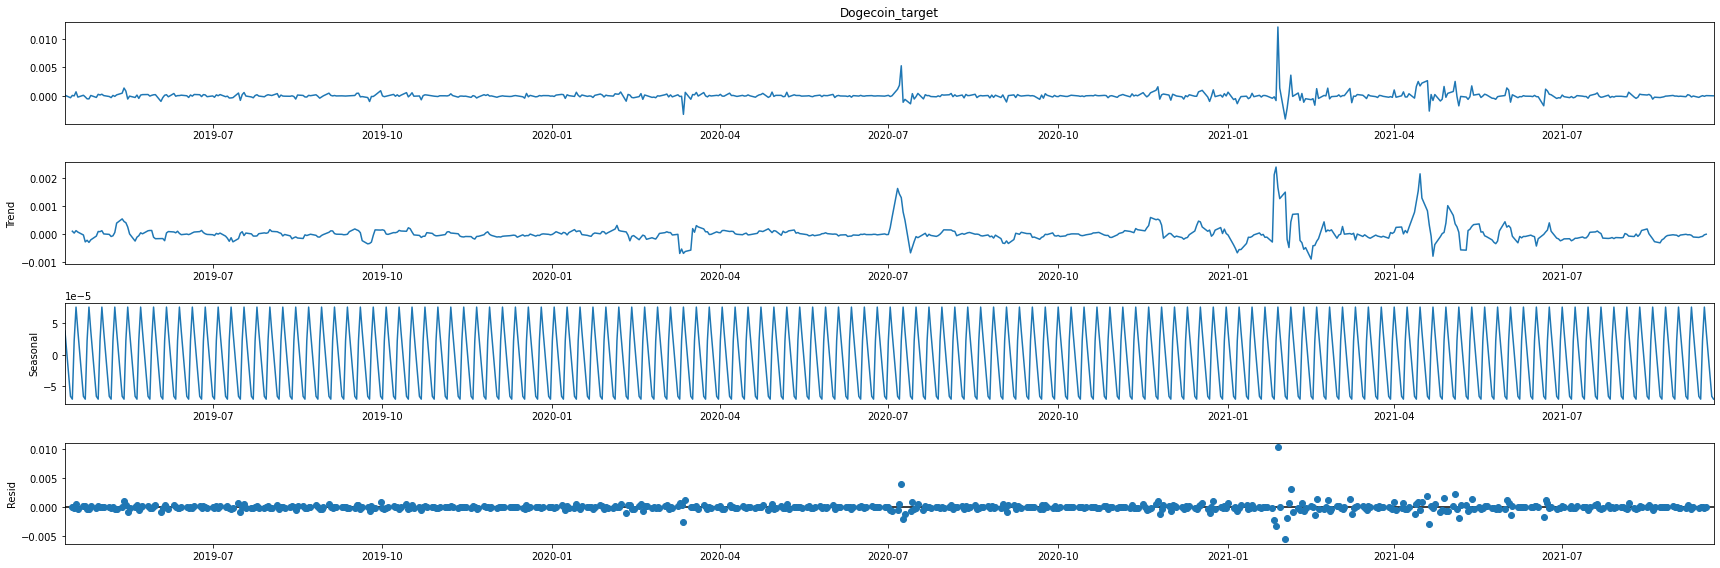

In [13]:
# time series decomposition of all currencies
plt.rc("figure", figsize=(24, 8))

for asset in assets:
    target_series = asset['df'].Target.rename(f'{asset["name"]}_target')
    target_resampled = target_series.resample('B').mean()
    
    decomposition = seasonal_decompose(target_resampled, model='additive')
    fig = decomposition.plot()
    plt.show()
    print(5 * '\n')

## Autocorrelation Plots

In [14]:
def plot_acfs(asset_df):
    fig, ax = plt.subplots(1, 3, figsize=(32, 8))
    
    plot_acf(asset_df.Target.resample('B').mean(), lags = 50, ax = ax[0])
    plot_acf(asset_df.Target.resample('W').mean(), lags = 40, ax = ax[1])
    plot_acf(asset_df.Target.resample('Q').mean(), lags = 9, ax = ax[2])
    
    plt.show()






Bitcoin Cash


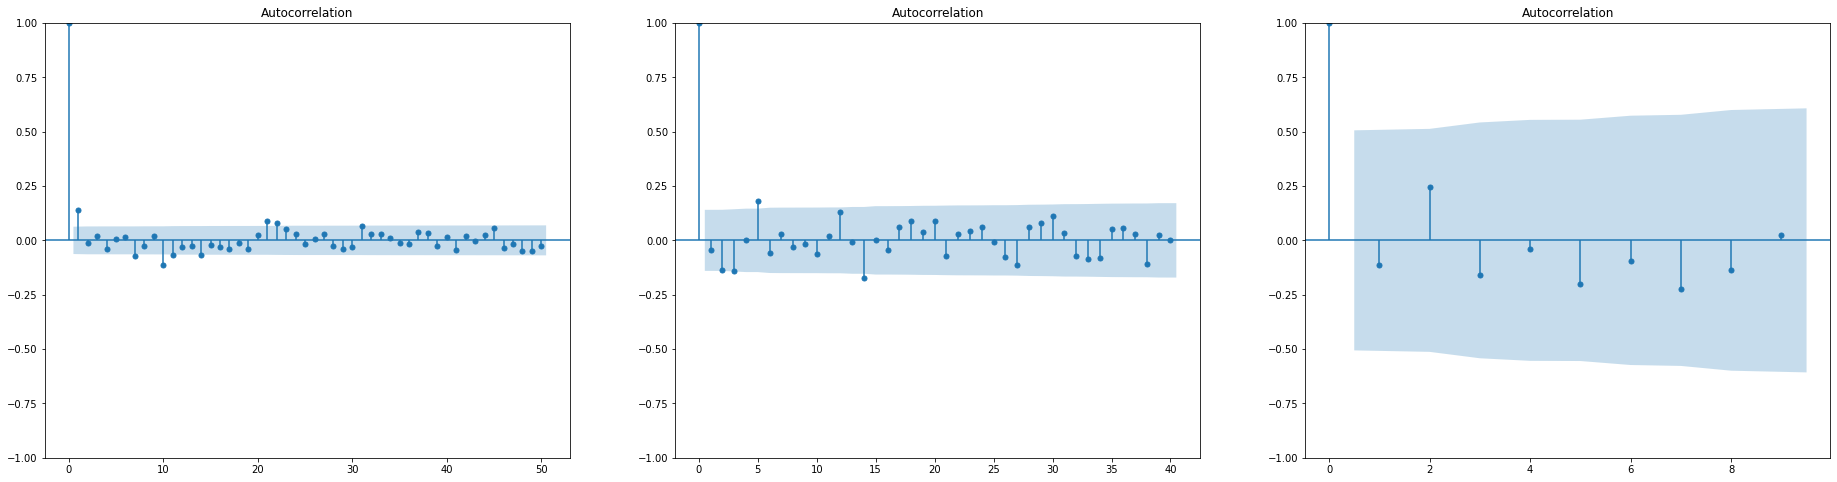






Binance Coin


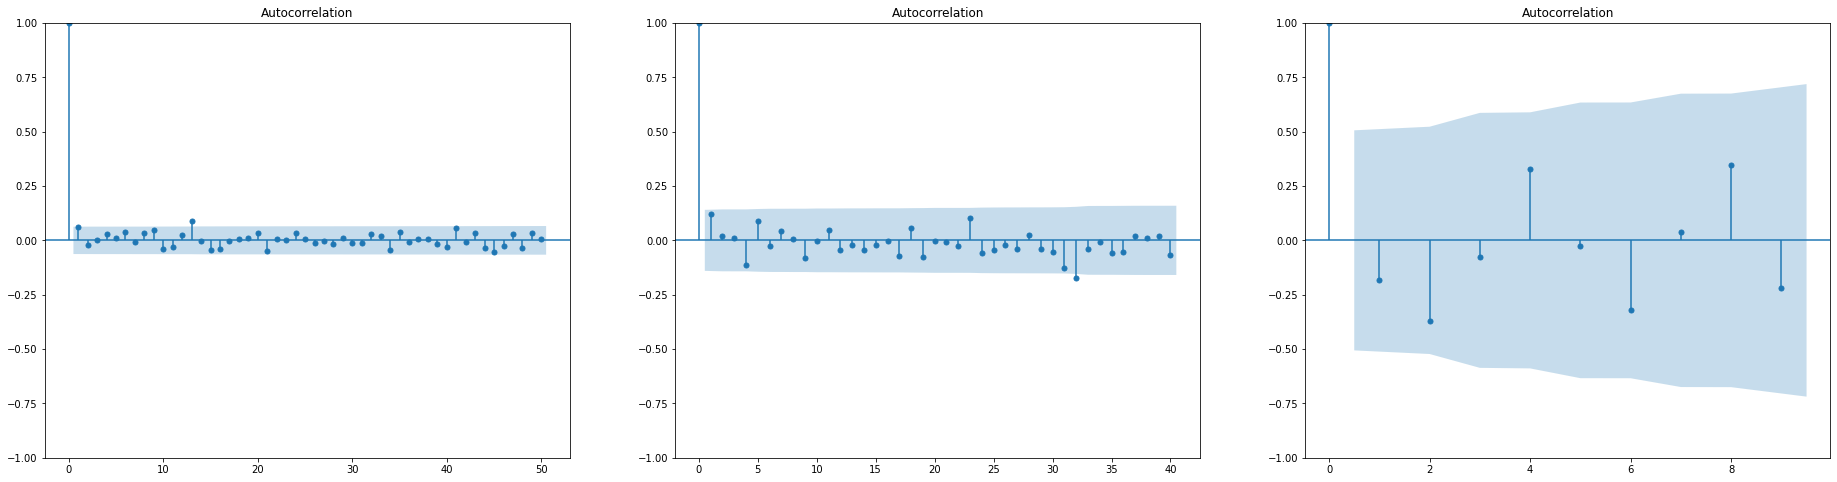






Bitcoin


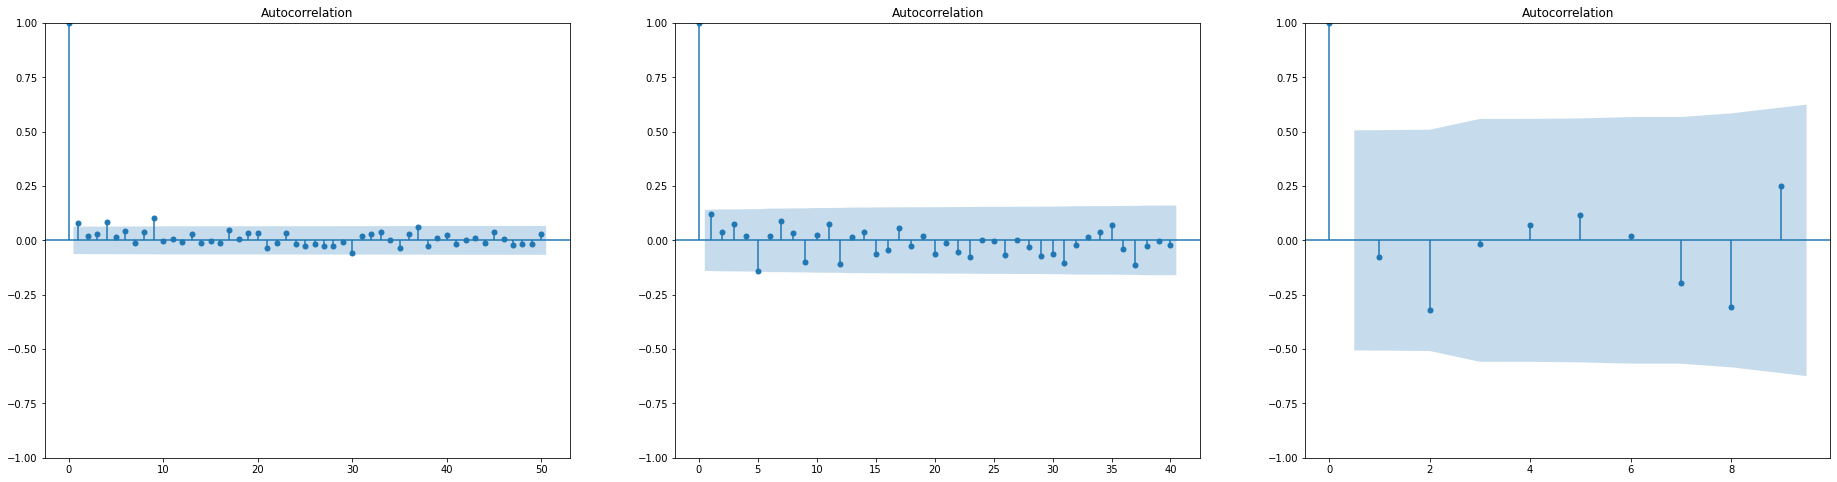






EOS.IO


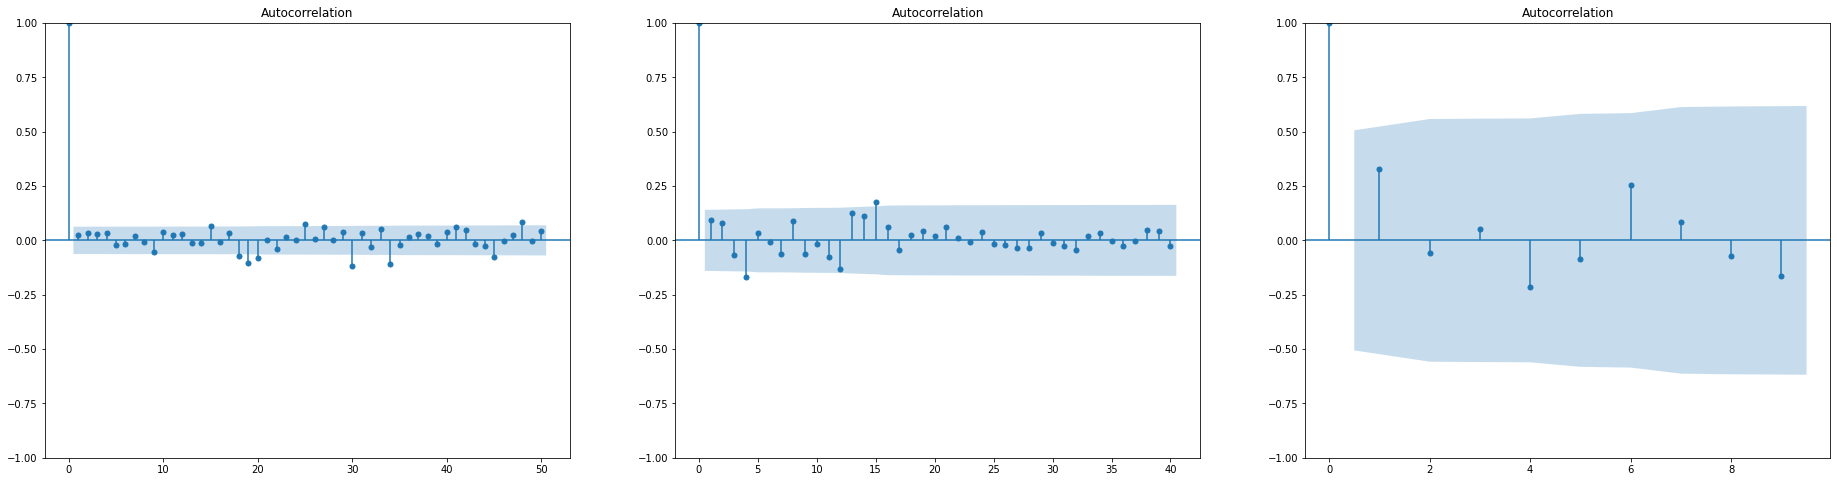






Ethereum Classic


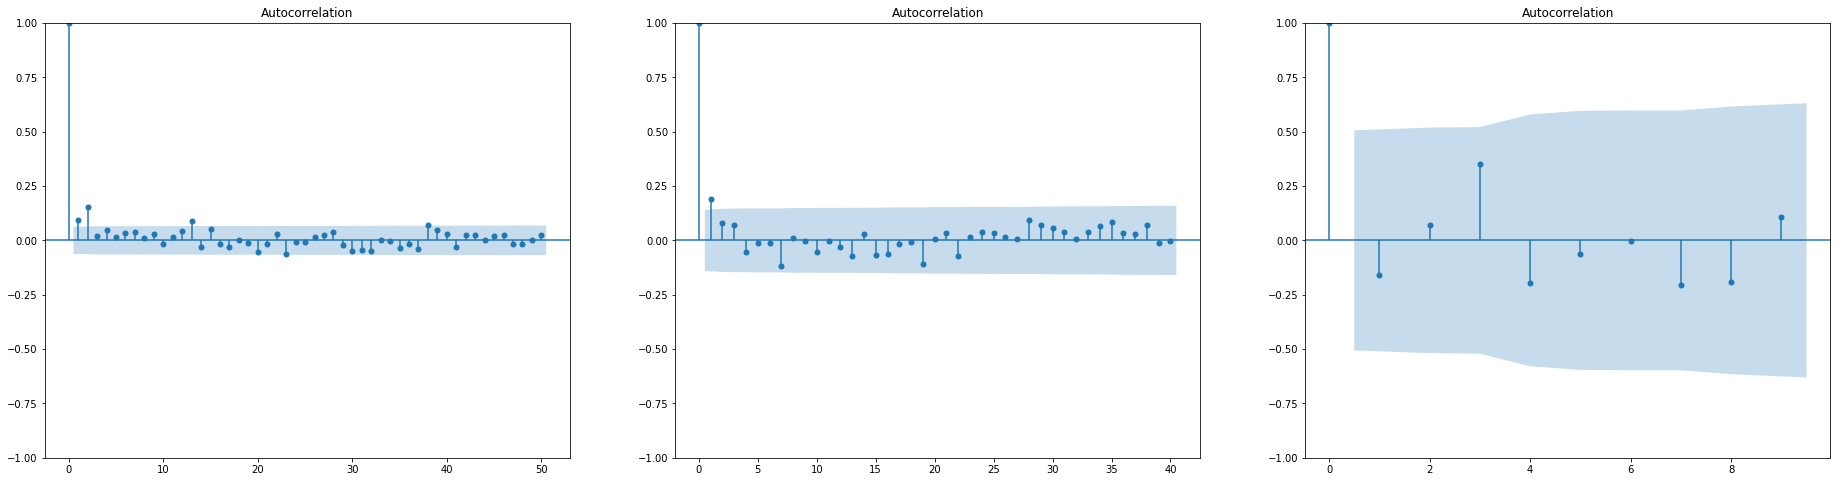






Ethereum


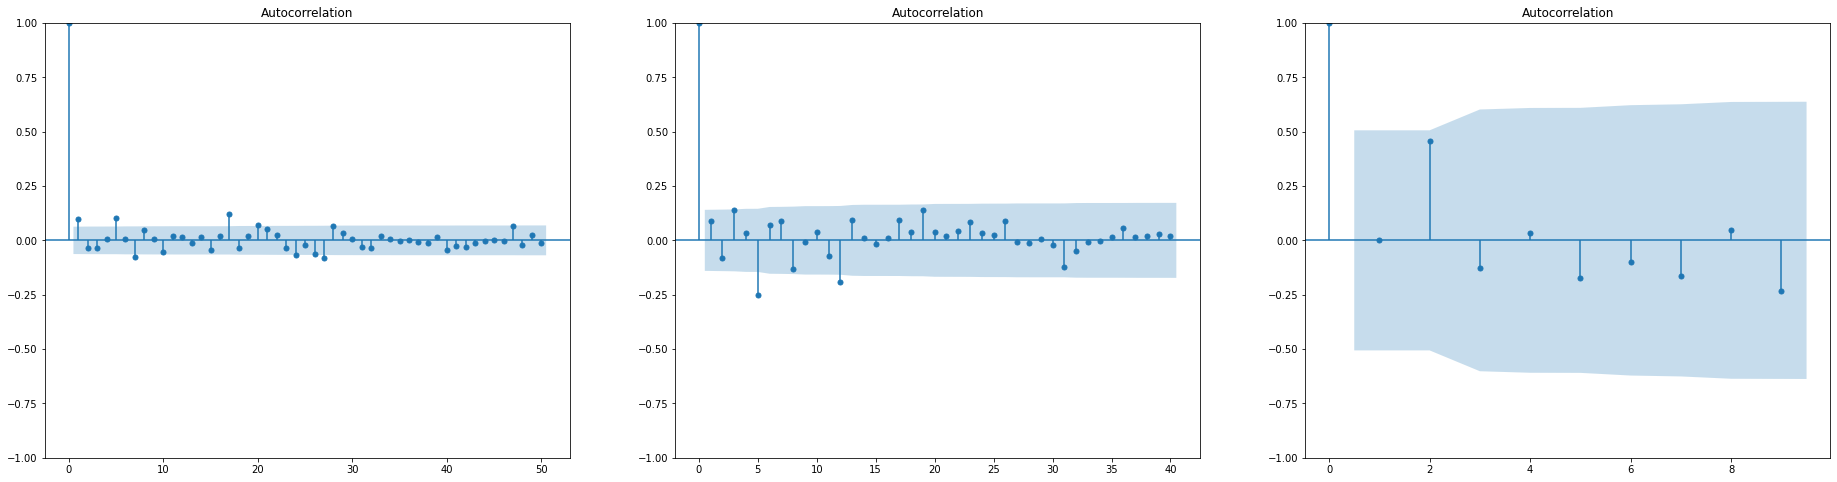






Litecoin


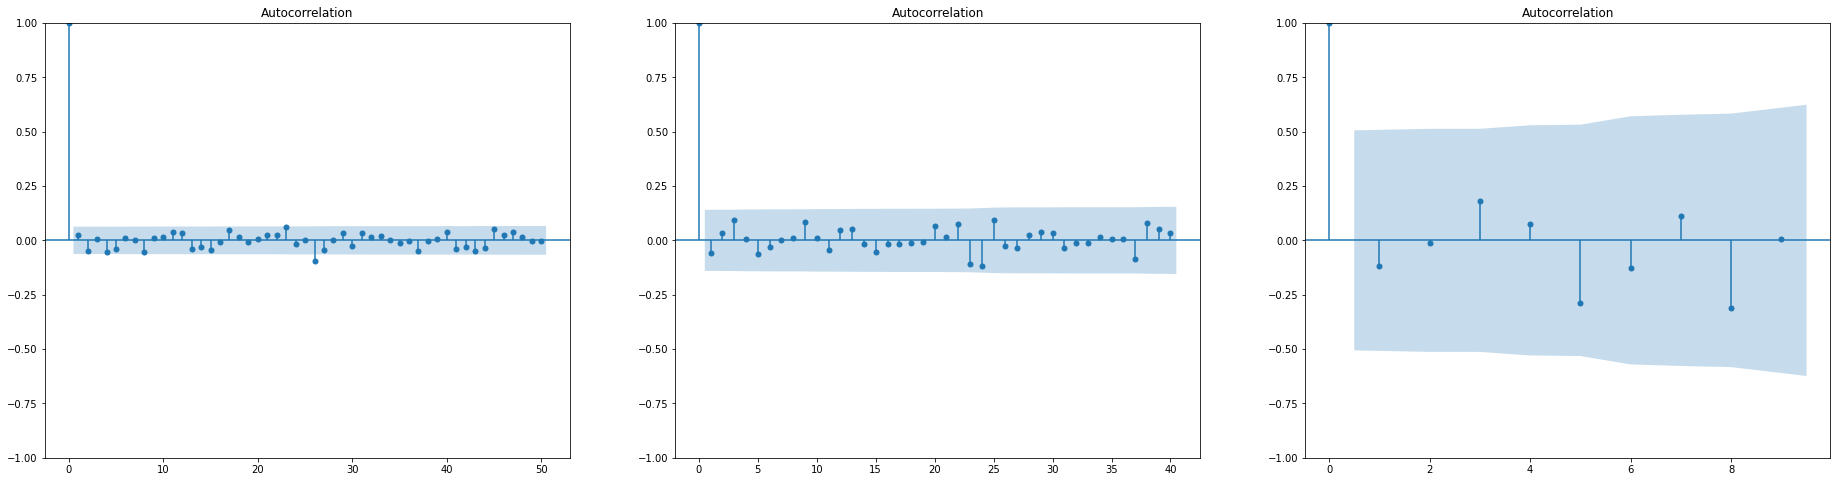






Monero


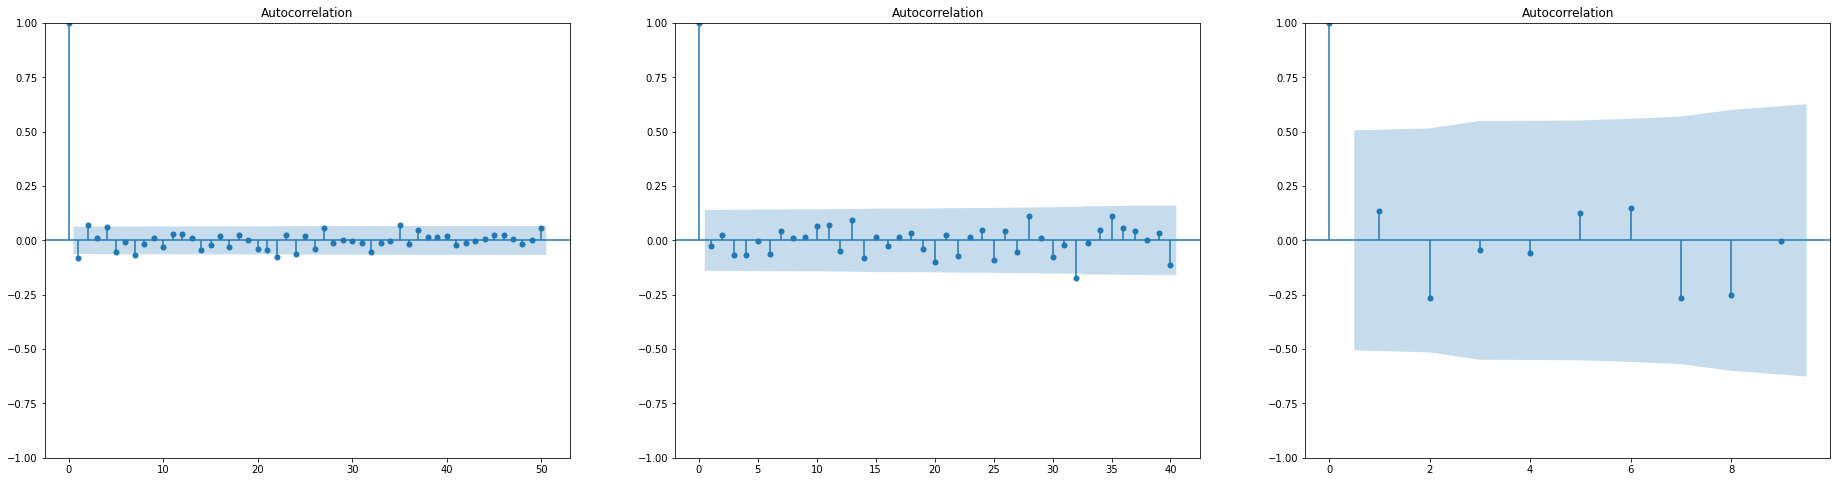






TRON


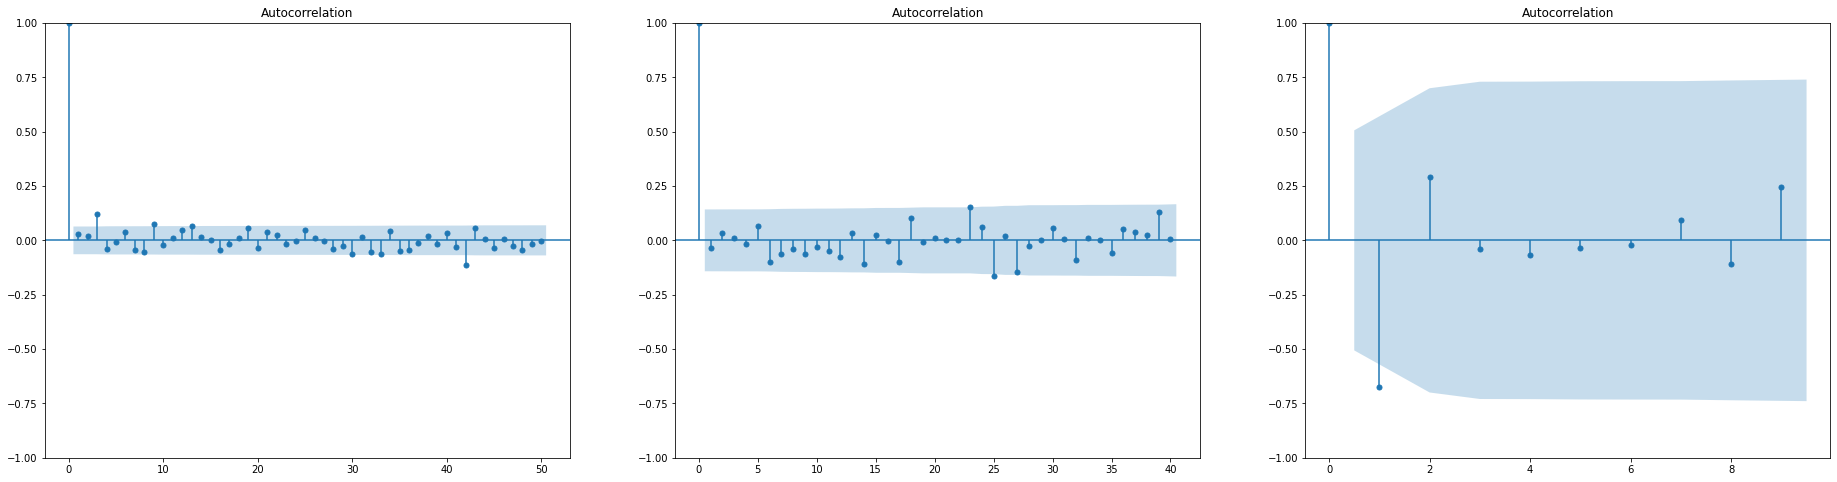






Stellar


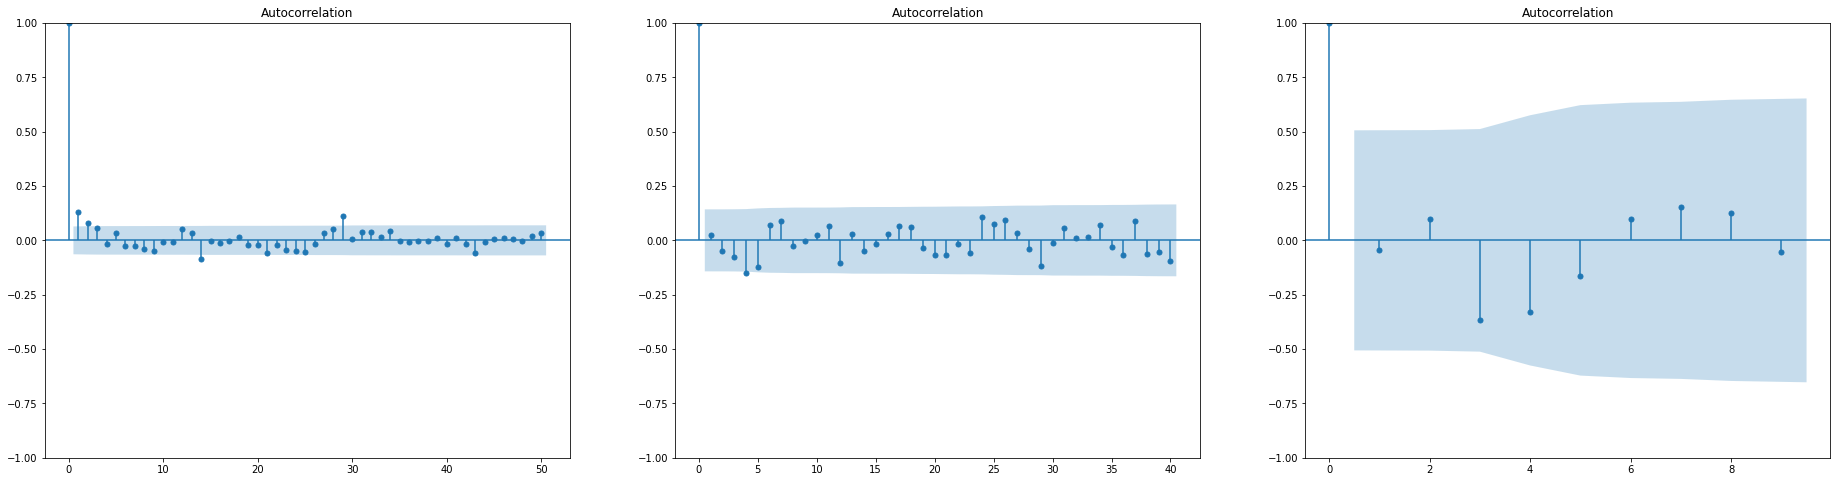






Cardano


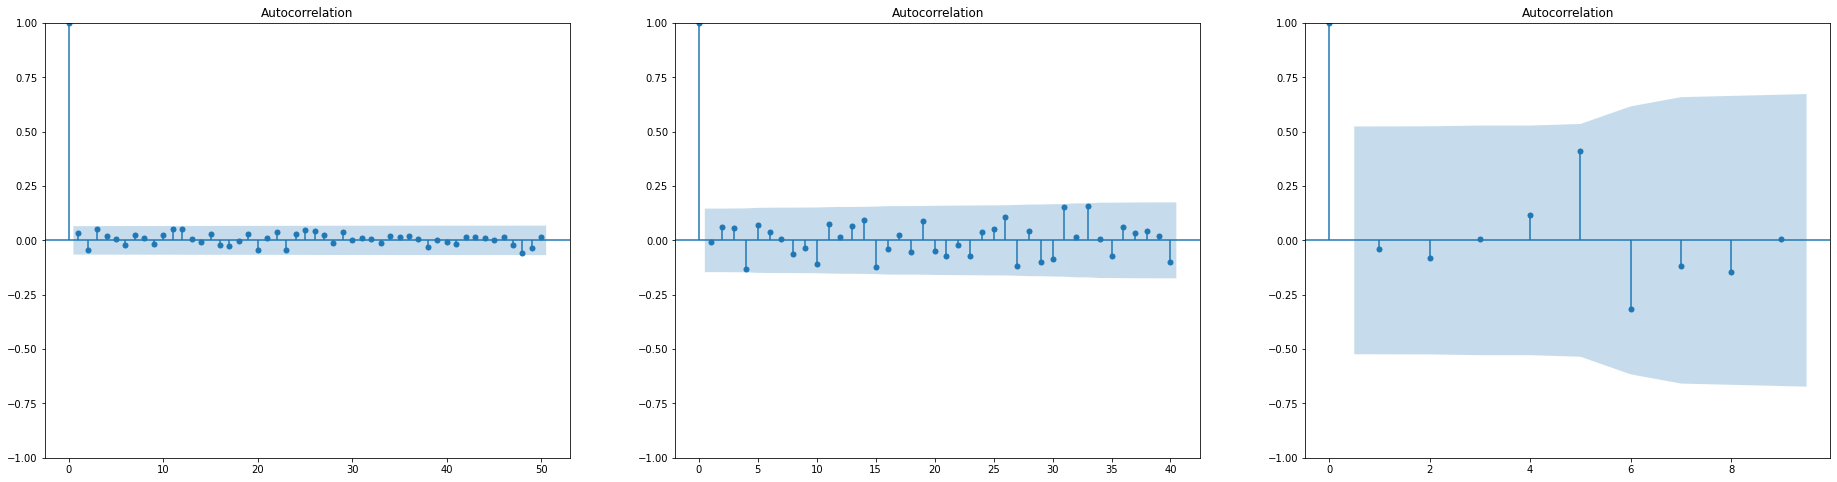






IOTA


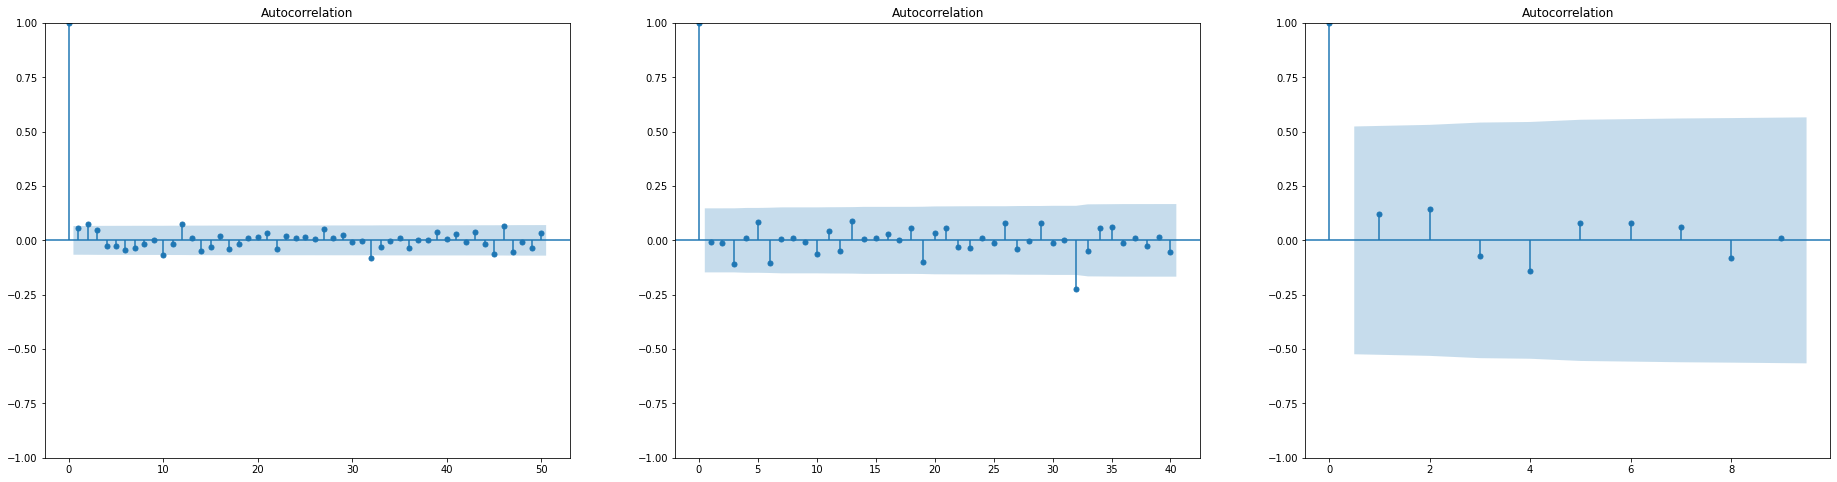






Maker


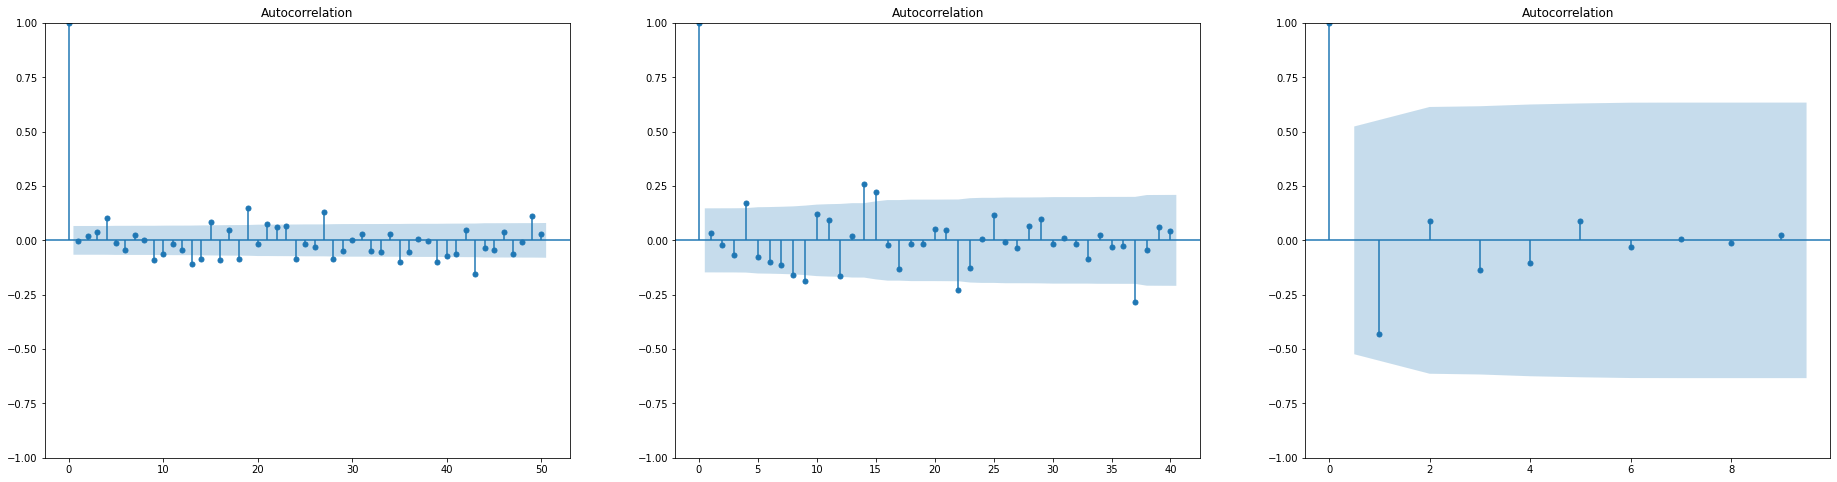






Dogecoin


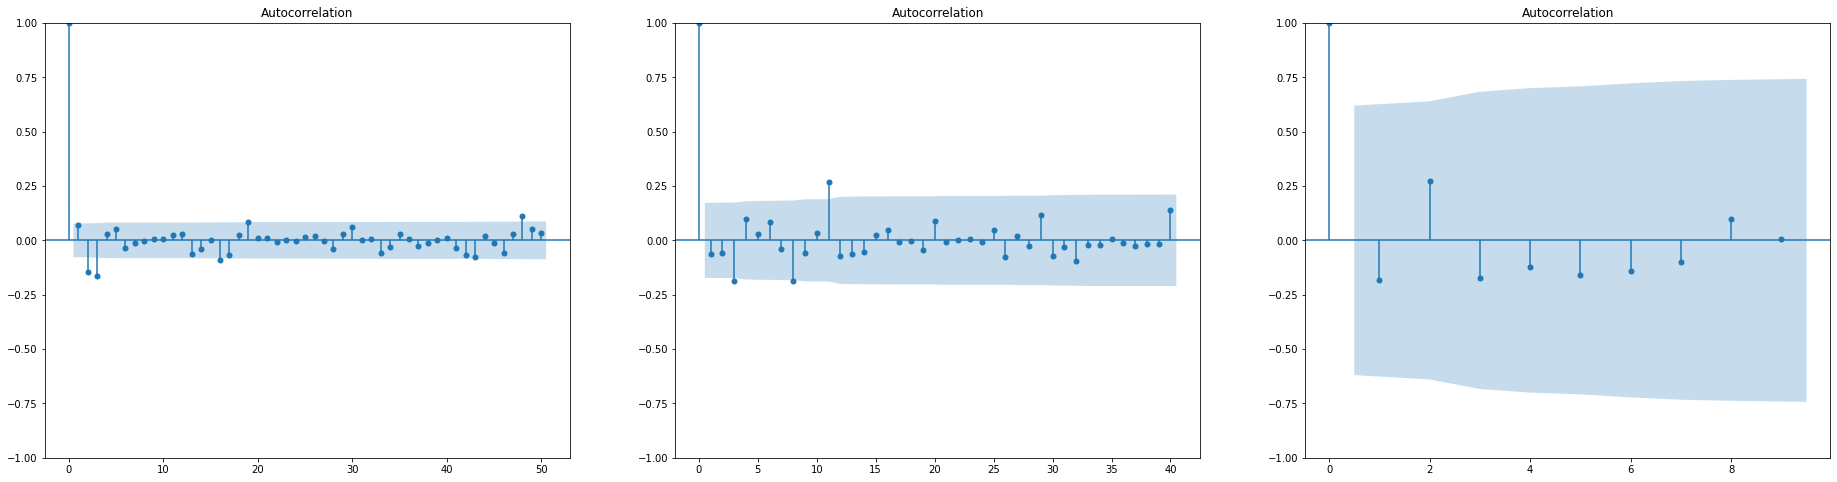

In [15]:
for asset in assets:
    print(5 * '\n' + '\033[1m' + asset['name'] + '\033[0m')
    plot_acfs(asset['df'])

## Check for stationarity

In [16]:
def check_stationarity(series, name):
    # ref: https://machinelearningmastery.com/time-series-data-stationary-python/

    result = adfuller(series.values)

    print(5 * '\n' + '\033[1m' + name + ': \033[0m')
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

In [17]:
for asset in assets:
    check_stationarity(asset['df'].Target.resample('15T').mean(), asset['name'])






Bitcoin Cash: 
ADF Statistic: -36.951701
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567
Stationary





Binance Coin: 
ADF Statistic: -37.486136
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567
Stationary





Bitcoin: 
ADF Statistic: -37.138814
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567
Stationary





EOS.IO: 
ADF Statistic: -40.074848
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567
Stationary





Ethereum Classic: 
ADF Statistic: -37.416759
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567
Stationary





Ethereum: 
ADF Statistic: -39.979008
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567
Stationary





Litecoin: 
ADF Statistic: -41.110241
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567
Stationary





Monero: 
ADF Statistic: -41.801435
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567


# Scratch

In [18]:
# script for checing null values and lags

# for asset in assets:
#     name = asset['name']
#     null_values = asset['df'].isna().sum()
#     lag_counts = (asset['df'].index[1:]-asset['df'].index[:-1]).value_counts()
    
#     print(f'null asset: {name}\n')
#     print(f'null values: {null_values}\n')
#     print(f'lag count: {lag_counts}\n')
#     print('----------------------------')